CPI_MOM Prediction Metrics (Test Set):
RMSE: 0.3741, MAE: 0.2971, MAPE: 0.30%
CPI_MOM Forecast Metrics (Test Period):
RMSE: 0.3932, MAE: 0.3107, MAPE: 0.31%

CPI_YOY Prediction Metrics (Test Set):
RMSE: 0.2273, MAE: 0.1864, MAPE: 0.18%
CPI_YOY Forecast Metrics (Test Period):
RMSE: 0.2340, MAE: 0.1867, MAPE: 0.18%


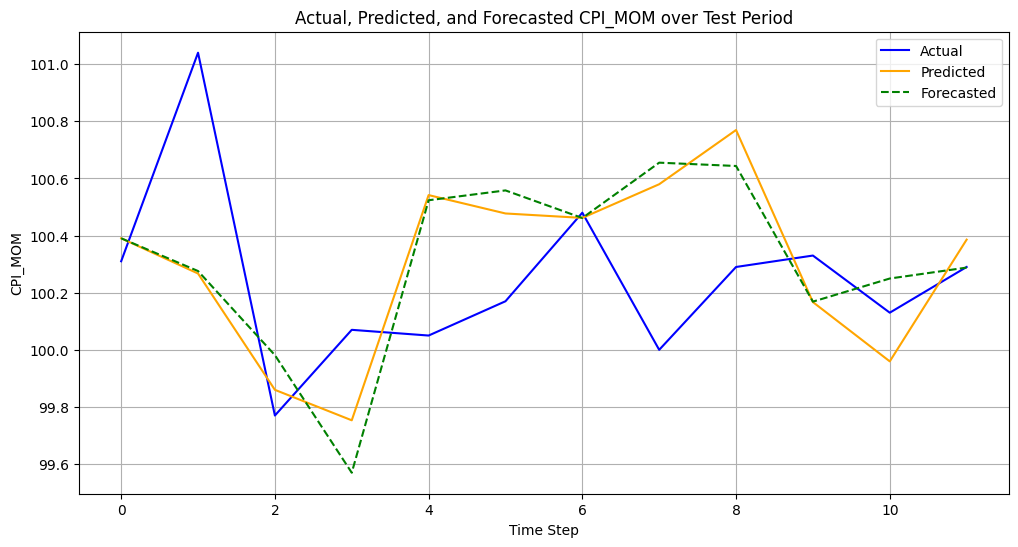

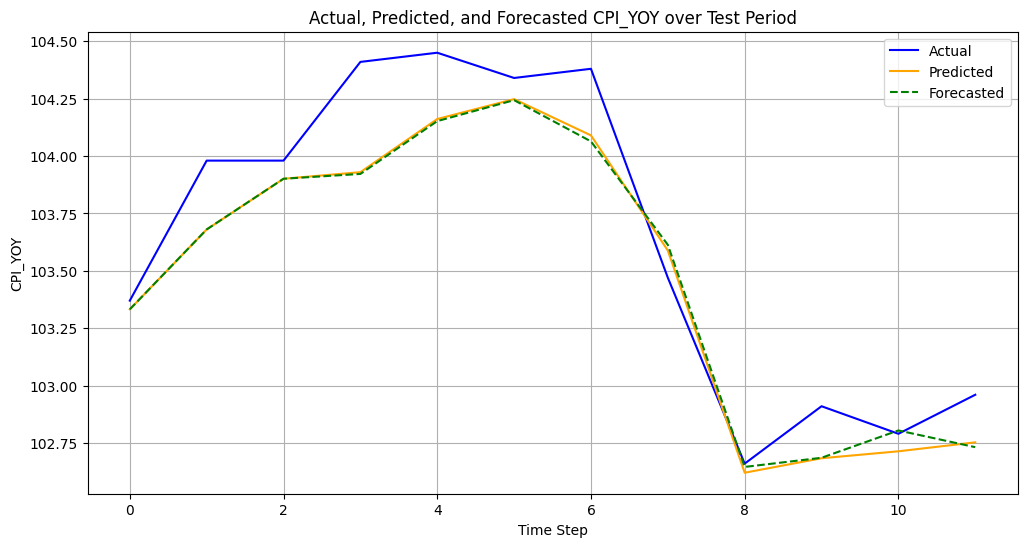


Forecast Results DataFrame:
         time  cpi_mom_actual  cpi_mom_predicted  cpi_mom_forecasted  \
0  2024-01-01          100.31         100.390399          100.390399   
1  2024-02-01          101.04         100.267063          100.275749   
2  2024-03-01           99.77          99.859946           99.981452   
3  2024-04-01          100.07          99.753282           99.569798   
4  2024-05-01          100.05         100.541625          100.523579   
5  2024-06-01          100.17         100.477318          100.558018   
6  2024-07-01          100.48         100.461791          100.461451   
7  2024-08-01          100.00         100.579658          100.655133   
8  2024-09-01          100.29         100.769462          100.643517   
9  2024-10-01          100.33         100.167064          100.168690   
10 2024-11-01          100.13          99.959580          100.249618   
11 2024-12-01          100.29         100.385717          100.287866   

    cpi_yoy_actual  cpi_yoy_predic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to create lagged features for residuals
def create_lagged_features(data, lags=12):
    df = pd.DataFrame()
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = data.shift(i)
    return df.dropna()

# Load and preprocess data
data = pd.read_csv('data/analyzed_time_series.csv', index_col='time', parse_dates=['time'])
test_size = 12
train_size = len(data) - test_size
train, test = data.iloc[:train_size], data.iloc[train_size:]

# --- Hybrid Model for CPI_MOM (SARIMA + RandomForest) ---
# Fit SARIMA
cpi_mom_train = train['cpi_mom']
sarima_mom_model = auto_arima(cpi_mom_train, seasonal=True, m=12, suppress_warnings=True)
sarima_mom = SARIMAX(cpi_mom_train, order=sarima_mom_model.order, 
                     seasonal_order=sarima_mom_model.seasonal_order).fit(disp=False)

# Calculate residuals
residuals_mom = cpi_mom_train - sarima_mom.fittedvalues

# Prepare lagged residuals for RandomForest
lags = 12
residuals_df_mom = create_lagged_features(residuals_mom, lags)
features_mom = residuals_df_mom
target_mom = residuals_mom.loc[residuals_df_mom.index]

# Train RandomForest
rf_mom = RandomForestRegressor(n_estimators=100, random_state=42)
rf_mom.fit(features_mom, target_mom)

# Predict on test set (using actual residuals)
sarima_pred_mom_test = sarima_mom.forecast(steps=test_size)
residuals_pred_mom_test = []
last_residuals = residuals_mom.tail(lags).values[::-1]
for i in range(test_size):
    rf_pred_residual = rf_mom.predict([last_residuals])[0]
    residuals_pred_mom_test.append(rf_pred_residual)
    if i < test_size - 1:
        actual_residual = test['cpi_mom'].iloc[i] - sarima_pred_mom_test.iloc[i]
        last_residuals = np.roll(last_residuals, -1)
        last_residuals[-1] = actual_residual
hybrid_pred_mom_test = sarima_pred_mom_test + np.array(residuals_pred_mom_test)

# Forecast for test period (recursive, using predicted residuals)
hybrid_forecast_mom = []
last_residuals = residuals_mom.tail(lags).values[::-1]
for i in range(test_size):
    rf_forecast_residual = rf_mom.predict([last_residuals])[0]
    total_forecast = sarima_pred_mom_test.iloc[i] + rf_forecast_residual
    hybrid_forecast_mom.append(total_forecast)
    last_residuals = np.roll(last_residuals, -1)
    last_residuals[-1] = rf_forecast_residual  # Use predicted residual for forecasting

# Evaluate CPI_MOM
y_true_mom = test['cpi_mom'].values
y_pred_mom = hybrid_pred_mom_test.values
y_forecast_mom = np.array(hybrid_forecast_mom)
rmse_mom_pred = np.sqrt(mean_squared_error(y_true_mom, y_pred_mom))
mae_mom_pred = mean_absolute_error(y_true_mom, y_pred_mom)
mape_mom_pred = mean_absolute_percentage_error(y_true_mom, y_pred_mom)
rmse_mom_forecast = np.sqrt(mean_squared_error(y_true_mom, y_forecast_mom))
mae_mom_forecast = mean_absolute_error(y_true_mom, y_forecast_mom)
mape_mom_forecast = mean_absolute_percentage_error(y_true_mom, y_forecast_mom)

# --- Hybrid Model for CPI_YOY (SARIMAX + Ridge) ---
# Fit SARIMAX
cpi_yoy_train = train['cpi_yoy']
exog_train = train[['oil_price']] if 'oil_price' in train.columns else None
exog_test = test[['oil_price']] if 'oil_price' in test.columns else None
sarimax_yoy_model = auto_arima(cpi_yoy_train, exogenous=exog_train, seasonal=True, m=12, 
                               suppress_warnings=True)
sarimax_yoy = SARIMAX(cpi_yoy_train, order=sarimax_yoy_model.order, 
                      seasonal_order=sarimax_yoy_model.seasonal_order, 
                      exog=exog_train).fit(disp=False)

# Calculate residuals
residuals_yoy = cpi_yoy_train - sarimax_yoy.fittedvalues

# Prepare lagged residuals for Ridge
residuals_df_yoy = create_lagged_features(residuals_yoy, lags)
features_yoy = residuals_df_yoy
target_yoy = residuals_yoy.loc[residuals_df_yoy.index]

# Train Ridge
ridge_yoy = Ridge(alpha=1.0)
ridge_yoy.fit(features_yoy, target_yoy)

# Predict on test set (using actual residuals)
sarimax_pred_yoy_test = sarimax_yoy.forecast(steps=test_size, exog=exog_test)
residuals_pred_yoy_test = []
last_residuals_yoy = residuals_yoy.tail(lags).values[::-1]
for i in range(test_size):
    ridge_pred_residual = ridge_yoy.predict([last_residuals_yoy])[0]
    residuals_pred_yoy_test.append(ridge_pred_residual)
    if i < test_size - 1:
        actual_residual = test['cpi_yoy'].iloc[i] - sarimax_pred_yoy_test.iloc[i]
        last_residuals_yoy = np.roll(last_residuals_yoy, -1)
        last_residuals_yoy[-1] = actual_residual
hybrid_pred_yoy_test = sarimax_pred_yoy_test + np.array(residuals_pred_yoy_test)

# Forecast for test period (recursive, using predicted residuals)
hybrid_forecast_yoy = []
last_residuals_yoy = residuals_yoy.tail(lags).values[::-1]
for i in range(test_size):
    ridge_forecast_residual = ridge_yoy.predict([last_residuals_yoy])[0]
    total_forecast = sarimax_pred_yoy_test.iloc[i] + ridge_forecast_residual
    hybrid_forecast_yoy.append(total_forecast)
    last_residuals_yoy = np.roll(last_residuals_yoy, -1)
    last_residuals_yoy[-1] = ridge_forecast_residual  # Use predicted residual for forecasting

# Evaluate CPI_YOY
y_true_yoy = test['cpi_yoy'].values
y_pred_yoy = hybrid_pred_yoy_test.values
y_forecast_yoy = np.array(hybrid_forecast_yoy)
rmse_yoy_pred = np.sqrt(mean_squared_error(y_true_yoy, y_pred_yoy))
mae_yoy_pred = mean_absolute_error(y_true_yoy, y_pred_yoy)
mape_yoy_pred = mean_absolute_percentage_error(y_true_yoy, y_pred_yoy)
rmse_yoy_forecast = np.sqrt(mean_squared_error(y_true_yoy, y_forecast_yoy))
mae_yoy_forecast = mean_absolute_error(y_true_yoy, y_forecast_yoy)
mape_yoy_forecast = mean_absolute_percentage_error(y_true_yoy, y_forecast_yoy)

# Print evaluation metrics
print("CPI_MOM Prediction Metrics (Test Set):")
print(f"RMSE: {rmse_mom_pred:.4f}, MAE: {mae_mom_pred:.4f}, MAPE: {mape_mom_pred:.2f}%")
print("CPI_MOM Forecast Metrics (Test Period):")
print(f"RMSE: {rmse_mom_forecast:.4f}, MAE: {mae_mom_forecast:.4f}, MAPE: {mape_mom_forecast:.2f}%")
print("\nCPI_YOY Prediction Metrics (Test Set):")
print(f"RMSE: {rmse_yoy_pred:.4f}, MAE: {mae_yoy_pred:.4f}, MAPE: {mape_yoy_pred:.2f}%")
print("CPI_YOY Forecast Metrics (Test Period):")
print(f"RMSE: {rmse_yoy_forecast:.4f}, MAE: {mae_yoy_forecast:.4f}, MAPE: {mape_yoy_forecast:.2f}%")

# Plotting function (LSTM-style for test period)
def plot_results(y_test, predictions, forecasts, test_size=12, title="CPI"):
    plt.figure(figsize=(12, 6))
    plt.plot(range(test_size), y_test, label='Actual', color='blue')
    plt.plot(range(test_size), predictions, label='Predicted', color='orange')
    plt.plot(range(test_size), forecasts, label='Forecasted', color='green', linestyle='--')
    plt.title(f'Actual, Predicted, and Forecasted {title} over Test Period')
    plt.xlabel('Time Step')
    plt.ylabel(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'plots/{title.lower()}_test_period_plot.png')
    plt.show()

# Plot for CPI_MOM and CPI_YOY
plot_results(y_true_mom, y_pred_mom, y_forecast_mom, test_size, title='CPI_MOM')
plot_results(y_true_yoy, y_pred_yoy, y_forecast_yoy, test_size, title='CPI_YOY')

# Save results to CSV
forecast_df = pd.DataFrame({
    'time': test.index,
    'cpi_mom_actual': y_true_mom,
    'cpi_mom_predicted': y_pred_mom,
    'cpi_mom_forecasted': y_forecast_mom,
    'cpi_yoy_actual': y_true_yoy,
    'cpi_yoy_predicted': y_pred_yoy,
    'cpi_yoy_forecasted': y_forecast_yoy
})
forecast_df.to_csv('plots/cpi_forecast_results.csv', index=False)
print("\nForecast Results DataFrame:")
print(forecast_df)

CPI_MOM Prediction Metrics (Test Set):
RMSE: 0.5376, MAE: 0.4502, MAPE: 0.45%
CPI_MOM Forecast Metrics (Test Period):
RMSE: 0.4851, MAE: 0.4199, MAPE: 0.42%

CPI_YOY Prediction Metrics (Test Set):
RMSE: 0.2977, MAE: 0.2058, MAPE: 0.20%
CPI_YOY Forecast Metrics (Test Period):
RMSE: 0.3643, MAE: 0.2716, MAPE: 0.26%


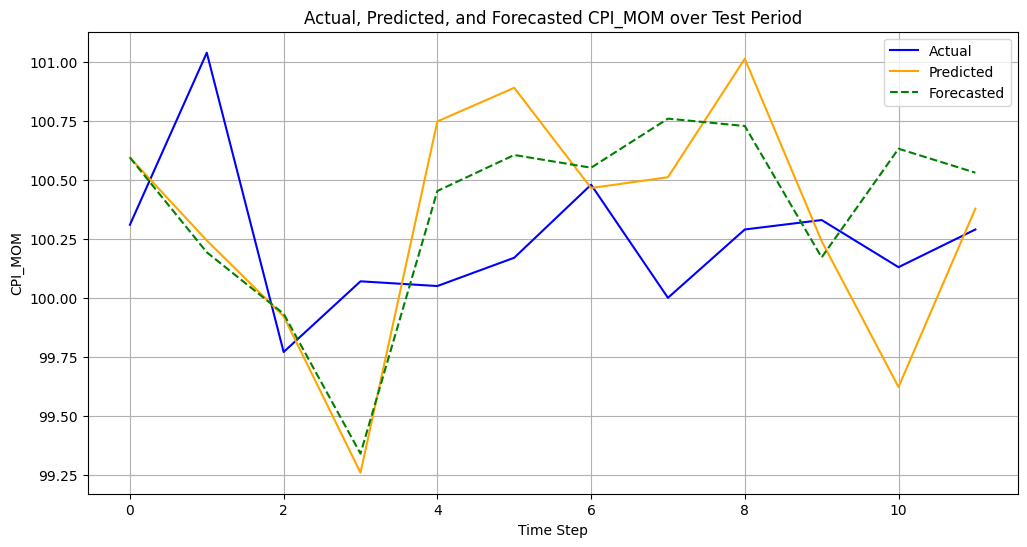

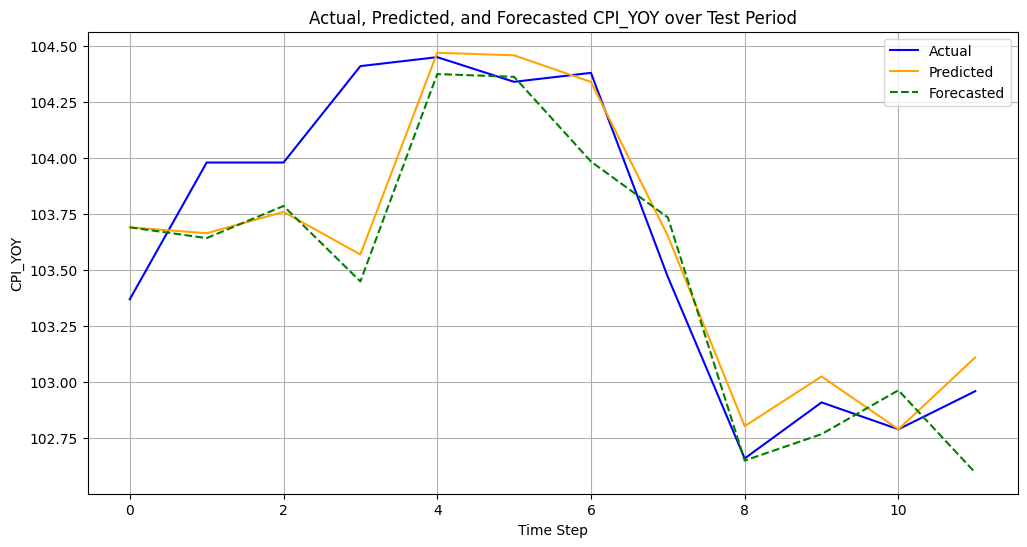


Forecast Results DataFrame:
         time  cpi_mom_actual  cpi_mom_predicted  cpi_mom_forecasted  \
0  2024-01-01          100.31         100.595096          100.595096   
1  2024-02-01          101.04         100.243207          100.193171   
2  2024-03-01           99.77          99.921648           99.932255   
3  2024-04-01          100.07          99.257769           99.338706   
4  2024-05-01          100.05         100.748414          100.453366   
5  2024-06-01          100.17         100.891220          100.606021   
6  2024-07-01          100.48         100.465835          100.552059   
7  2024-08-01          100.00         100.511712          100.760318   
8  2024-09-01          100.29         101.014429          100.729026   
9  2024-10-01          100.33         100.240524          100.171661   
10 2024-11-01          100.13          99.621554          100.632622   
11 2024-12-01          100.29         100.378491          100.530995   

    cpi_yoy_actual  cpi_yoy_predic

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to create lagged features for residuals
def create_lagged_features(data, lags=12):
    df = pd.DataFrame()
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = data.shift(i)
    return df.dropna()

# Load and preprocess data
data = pd.read_csv('data/analyzed_time_series.csv', index_col='time', parse_dates=['time'])
test_size = 12
train_size = len(data) - test_size
train, test = data.iloc[:train_size], data.iloc[train_size:]

# --- Hybrid Model for CPI_MOM (SARIMA + XGBoost) ---
# Fit SARIMA
cpi_mom_train = train['cpi_mom']
sarima_mom_model = auto_arima(cpi_mom_train, seasonal=True, m=12, suppress_warnings=True)
sarima_mom = SARIMAX(cpi_mom_train, order=sarima_mom_model.order, 
                     seasonal_order=sarima_mom_model.seasonal_order).fit(disp=False)

# Calculate residuals
residuals_mom = cpi_mom_train - sarima_mom.fittedvalues

# Prepare lagged residuals for XGBoost
lags = 12
residuals_df_mom = create_lagged_features(residuals_mom, lags)
features_mom = residuals_df_mom
target_mom = residuals_mom.loc[residuals_df_mom.index]

# Train XGBoost
xgb_mom = XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
xgb_mom.fit(features_mom, target_mom)

# Predict on test set (using actual residuals)
sarima_pred_mom_test = sarima_mom.forecast(steps=test_size)
residuals_pred_mom_test = []
last_residuals = residuals_mom.tail(lags).values[::-1]
for i in range(test_size):
    xgb_pred_residual = xgb_mom.predict([last_residuals])[0]
    residuals_pred_mom_test.append(xgb_pred_residual)
    if i < test_size - 1:
        actual_residual = test['cpi_mom'].iloc[i] - sarima_pred_mom_test.iloc[i]
        last_residuals = np.roll(last_residuals, -1)
        last_residuals[-1] = actual_residual
hybrid_pred_mom_test = sarima_pred_mom_test + np.array(residuals_pred_mom_test)

# Forecast for test period (recursive, using predicted residuals)
hybrid_forecast_mom = []
last_residuals = residuals_mom.tail(lags).values[::-1]
for i in range(test_size):
    xgb_forecast_residual = xgb_mom.predict([last_residuals])[0]
    total_forecast = sarima_pred_mom_test.iloc[i] + xgb_forecast_residual
    hybrid_forecast_mom.append(total_forecast)
    last_residuals = np.roll(last_residuals, -1)
    last_residuals[-1] = xgb_forecast_residual  # Use predicted residual for forecasting

# Evaluate CPI_MOM
y_true_mom = test['cpi_mom'].values
y_pred_mom = hybrid_pred_mom_test.values
y_forecast_mom = np.array(hybrid_forecast_mom)
rmse_mom_pred = np.sqrt(mean_squared_error(y_true_mom, y_pred_mom))
mae_mom_pred = mean_absolute_error(y_true_mom, y_pred_mom)
mape_mom_pred = mean_absolute_percentage_error(y_true_mom, y_pred_mom)
rmse_mom_forecast = np.sqrt(mean_squared_error(y_true_mom, y_forecast_mom))
mae_mom_forecast = mean_absolute_error(y_true_mom, y_forecast_mom)
mape_mom_forecast = mean_absolute_percentage_error(y_true_mom, y_forecast_mom)

# --- Hybrid Model for CPI_YOY (SARIMAX + XGBoost) ---
# Fit SARIMAX
cpi_yoy_train = train['cpi_yoy']
exog_train = train[['oil_price']] if 'oil_price' in train.columns else None
exog_test = test[['oil_price']] if 'oil_price' in test.columns else None
sarimax_yoy_model = auto_arima(cpi_yoy_train, exogenous=exog_train, seasonal=True, m=12, 
                               suppress_warnings=True)
sarimax_yoy = SARIMAX(cpi_yoy_train, order=sarimax_yoy_model.order, 
                      seasonal_order=sarimax_yoy_model.seasonal_order, 
                      exog=exog_train).fit(disp=False)

# Calculate residuals
residuals_yoy = cpi_yoy_train - sarimax_yoy.fittedvalues

# Prepare lagged residuals for XGBoost
residuals_df_yoy = create_lagged_features(residuals_yoy, lags)
features_yoy = residuals_df_yoy
target_yoy = residuals_yoy.loc[residuals_df_yoy.index]

# Train XGBoost
xgb_yoy = XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
xgb_yoy.fit(features_yoy, target_yoy)

# Predict on test set (using actual residuals)
sarimax_pred_yoy_test = sarimax_yoy.forecast(steps=test_size, exog=exog_test)
residuals_pred_yoy_test = []
last_residuals_yoy = residuals_yoy.tail(lags).values[::-1]
for i in range(test_size):
    xgb_pred_residual = xgb_yoy.predict([last_residuals_yoy])[0]
    residuals_pred_yoy_test.append(xgb_pred_residual)
    if i < test_size - 1:
        actual_residual = test['cpi_yoy'].iloc[i] - sarimax_pred_yoy_test.iloc[i]
        last_residuals_yoy = np.roll(last_residuals_yoy, -1)
        last_residuals_yoy[-1] = actual_residual
hybrid_pred_yoy_test = sarimax_pred_yoy_test + np.array(residuals_pred_yoy_test)

# Forecast for test period (recursive, using predicted residuals)
hybrid_forecast_yoy = []
last_residuals_yoy = residuals_yoy.tail(lags).values[::-1]
for i in range(test_size):
    xgb_forecast_residual = xgb_yoy.predict([last_residuals_yoy])[0]
    total_forecast = sarimax_pred_yoy_test.iloc[i] + xgb_forecast_residual
    hybrid_forecast_yoy.append(total_forecast)
    last_residuals_yoy = np.roll(last_residuals_yoy, -1)
    last_residuals_yoy[-1] = xgb_forecast_residual  # Use predicted residual for forecasting

# Evaluate CPI_YOY
y_true_yoy = test['cpi_yoy'].values
y_pred_yoy = hybrid_pred_yoy_test.values
y_forecast_yoy = np.array(hybrid_forecast_yoy)
rmse_yoy_pred = np.sqrt(mean_squared_error(y_true_yoy, y_pred_yoy))
mae_yoy_pred = mean_absolute_error(y_true_yoy, y_pred_yoy)
mape_yoy_pred = mean_absolute_percentage_error(y_true_yoy, y_pred_yoy)
rmse_yoy_forecast = np.sqrt(mean_squared_error(y_true_yoy, y_forecast_yoy))
mae_yoy_forecast = mean_absolute_error(y_true_yoy, y_forecast_yoy)
mape_yoy_forecast = mean_absolute_percentage_error(y_true_yoy, y_forecast_yoy)

# Print evaluation metrics
print("CPI_MOM Prediction Metrics (Test Set):")
print(f"RMSE: {rmse_mom_pred:.4f}, MAE: {mae_mom_pred:.4f}, MAPE: {mape_mom_pred:.2f}%")
print("CPI_MOM Forecast Metrics (Test Period):")
print(f"RMSE: {rmse_mom_forecast:.4f}, MAE: {mae_mom_forecast:.4f}, MAPE: {mape_mom_forecast:.2f}%")
print("\nCPI_YOY Prediction Metrics (Test Set):")
print(f"RMSE: {rmse_yoy_pred:.4f}, MAE: {mae_yoy_pred:.4f}, MAPE: {mape_yoy_pred:.2f}%")
print("CPI_YOY Forecast Metrics (Test Period):")
print(f"RMSE: {rmse_yoy_forecast:.4f}, MAE: {mae_yoy_forecast:.4f}, MAPE: {mape_yoy_forecast:.2f}%")

# Plotting function (LSTM-style for test period)
def plot_results(y_test, predictions, forecasts, test_size=12, title="CPI"):
    plt.figure(figsize=(12, 6))
    plt.plot(range(test_size), y_test, label='Actual', color='blue')
    plt.plot(range(test_size), predictions, label='Predicted', color='orange')
    plt.plot(range(test_size), forecasts, label='Forecasted', color='green', linestyle='--')
    plt.title(f'Actual, Predicted, and Forecasted {title} over Test Period')
    plt.xlabel('Time Step')
    plt.ylabel(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'plots/{title.lower()}_test_period_plot.png')
    plt.show()

# Plot for CPI_MOM and CPI_YOY
plot_results(y_true_mom, y_pred_mom, y_forecast_mom, test_size, title='CPI_MOM')
plot_results(y_true_yoy, y_pred_yoy, y_forecast_yoy, test_size, title='CPI_YOY')

# Save results to CSV
forecast_df = pd.DataFrame({
    'time': test.index,
    'cpi_mom_actual': y_true_mom,
    'cpi_mom_predicted': y_pred_mom,
    'cpi_mom_forecasted': y_forecast_mom,
    'cpi_yoy_actual': y_true_yoy,
    'cpi_yoy_predicted': y_pred_yoy,
    'cpi_yoy_forecasted': y_forecast_yoy
})
forecast_df.to_csv('plots/cpi_forecast_results_xgboost.csv', index=False)
print("\nForecast Results DataFrame:")
print(forecast_df)


Running Hybrid Model: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1312
[LightGBM] [Info] Number of data points in the train set: 325, number of used features: 12
[LightGBM] [Info] Start training from score 0.000789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

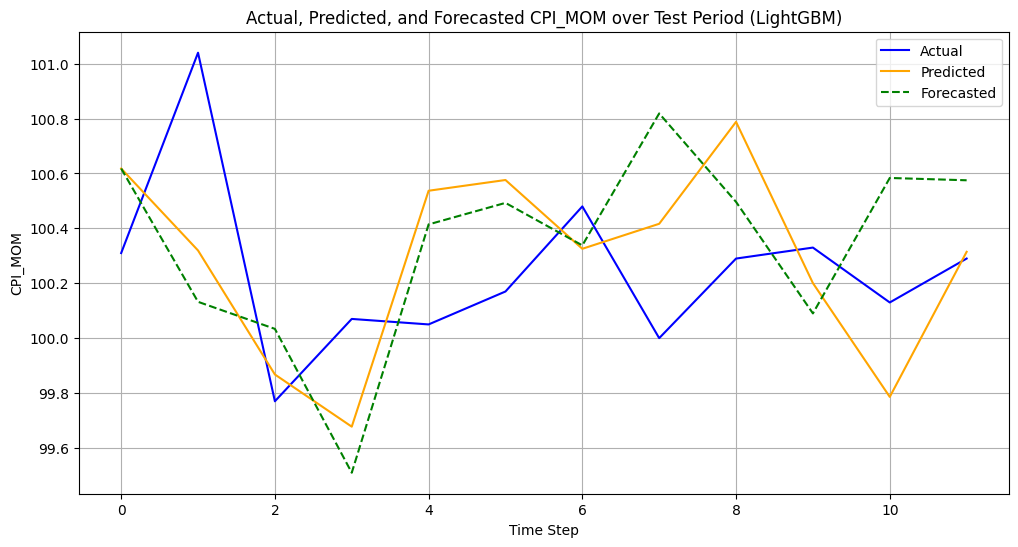

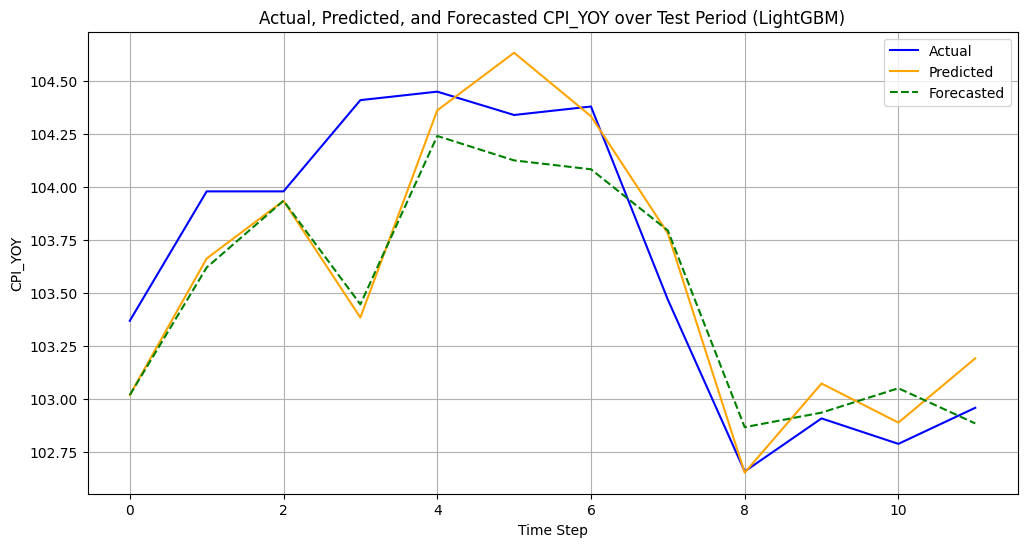


Forecast Results DataFrame for LightGBM:
         time  cpi_mom_actual  cpi_mom_predicted  cpi_mom_forecasted  \
0  2024-01-01          100.31         100.618034          100.618034   
1  2024-02-01          101.04         100.319467          100.132404   
2  2024-03-01           99.77          99.867619          100.033796   
3  2024-04-01          100.07          99.677423           99.509646   
4  2024-05-01          100.05         100.537101          100.414421   
5  2024-06-01          100.17         100.576224          100.492845   
6  2024-07-01          100.48         100.325604          100.337952   
7  2024-08-01          100.00         100.416677          100.818751   
8  2024-09-01          100.29         100.788072          100.496450   
9  2024-10-01          100.33         100.200506          100.090163   
10 2024-11-01          100.13          99.785970          100.583671   
11 2024-12-01          100.29         100.314503          100.575202   

    cpi_yoy_actual  c

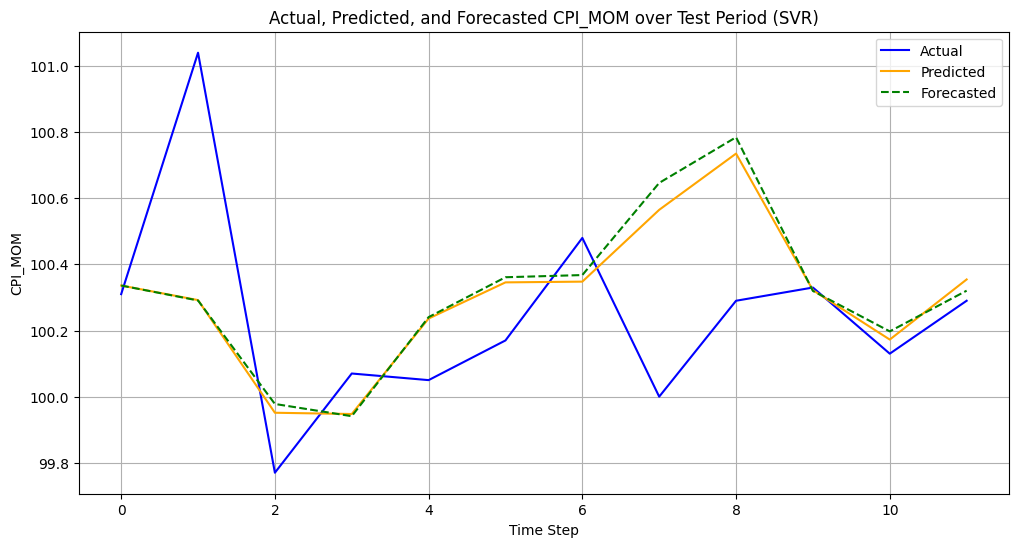

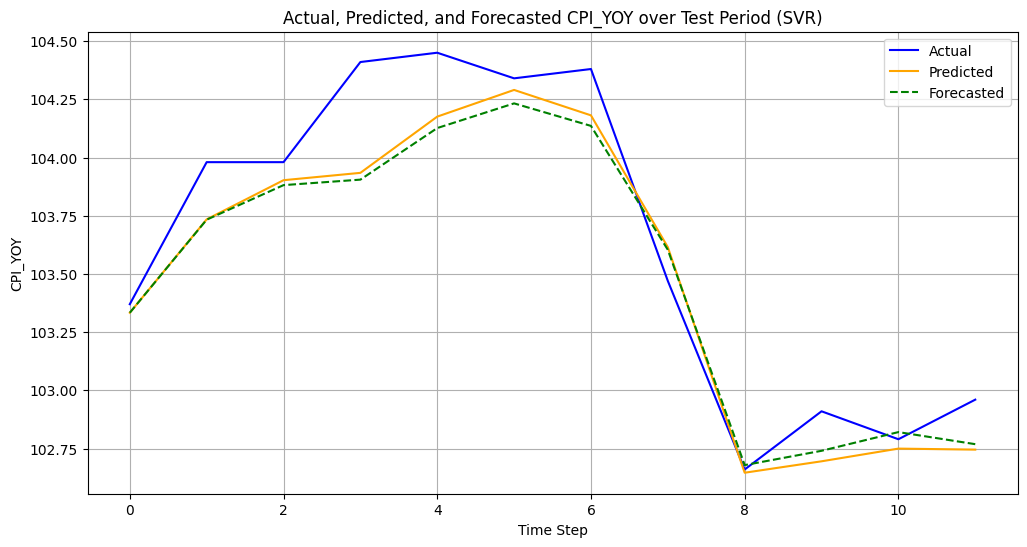


Forecast Results DataFrame for SVR:
         time  cpi_mom_actual  cpi_mom_predicted  cpi_mom_forecasted  \
0  2024-01-01          100.31         100.336071          100.336071   
1  2024-02-01          101.04         100.291951          100.290835   
2  2024-03-01           99.77          99.951355           99.977913   
3  2024-04-01          100.07          99.947530           99.940939   
4  2024-05-01          100.05         100.236191          100.240459   
5  2024-06-01          100.17         100.345571          100.361095   
6  2024-07-01          100.48         100.347806          100.367699   
7  2024-08-01          100.00         100.564924          100.646324   
8  2024-09-01          100.29         100.735006          100.784371   
9  2024-10-01          100.33         100.321861          100.319644   
10 2024-11-01          100.13         100.172586          100.197391   
11 2024-12-01          100.29         100.354390          100.320457   

    cpi_yoy_actual  cpi_yo

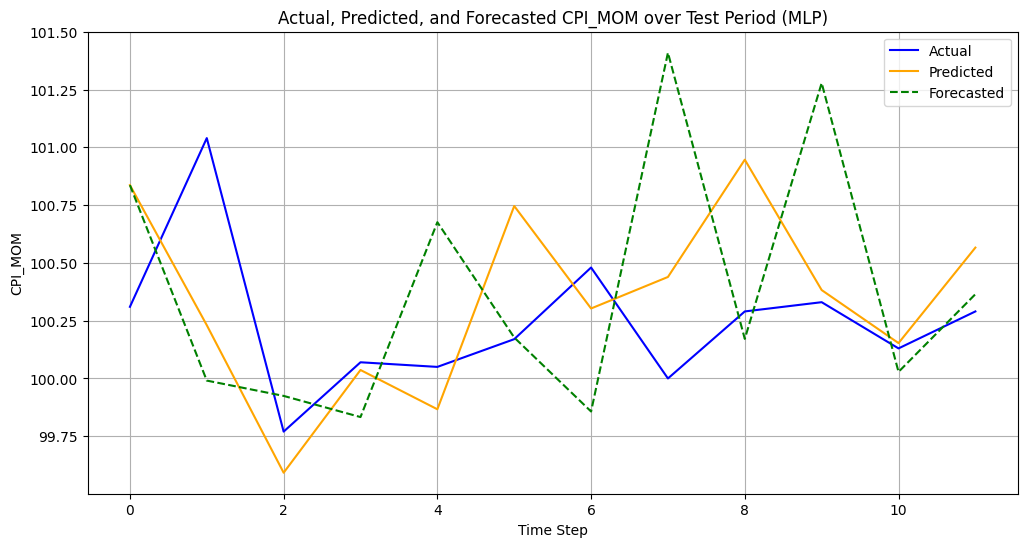

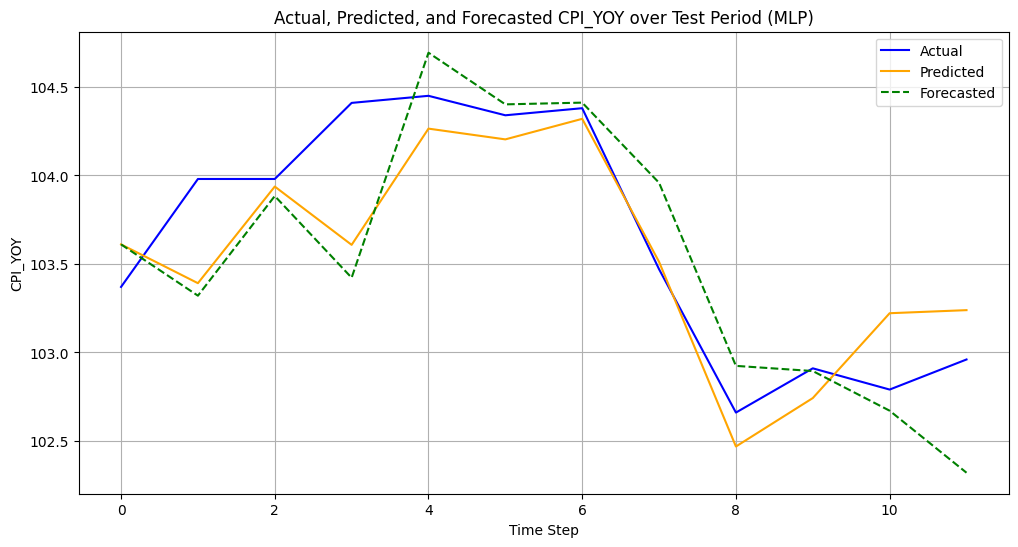


Forecast Results DataFrame for MLP:
         time  cpi_mom_actual  cpi_mom_predicted  cpi_mom_forecasted  \
0  2024-01-01          100.31         100.836584          100.836584   
1  2024-02-01          101.04         100.230523           99.990747   
2  2024-03-01           99.77          99.592088           99.924457   
3  2024-04-01          100.07         100.036613           99.832932   
4  2024-05-01          100.05          99.866644          100.676061   
5  2024-06-01          100.17         100.746189          100.177140   
6  2024-07-01          100.48         100.302787           99.857002   
7  2024-08-01          100.00         100.439110          101.409455   
8  2024-09-01          100.29         100.946615          100.171179   
9  2024-10-01          100.33         100.382498          101.278325   
10 2024-11-01          100.13         100.153021          100.028475   
11 2024-12-01          100.29         100.566223          100.364590   

    cpi_yoy_actual  cpi_yo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to create lagged features for residuals
def create_lagged_features(data, lags=12):
    df = pd.DataFrame()
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = data.shift(i)
    return df.dropna()

# Load and preprocess data
data = pd.read_csv('data/analyzed_time_series.csv', index_col='time', parse_dates=['time'])
test_size = 12
train_size = len(data) - test_size
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Initialize results dictionary to store metrics
results = {
    'Model': [],
    'CPI_MOM_RMSE_Pred': [], 'CPI_MOM_MAE_Pred': [], 'CPI_MOM_MAPE_Pred': [],
    'CPI_MOM_RMSE_Forecast': [], 'CPI_MOM_MAE_Forecast': [], 'CPI_MOM_MAPE_Forecast': [],
    'CPI_YOY_RMSE_Pred': [], 'CPI_YOY_MAE_Pred': [], 'CPI_YOY_MAPE_Pred': [],
    'CPI_YOY_RMSE_Forecast': [], 'CPI_YOY_MAE_Forecast': [], 'CPI_YOY_MAPE_Forecast': []
}

# Function to train and evaluate hybrid model
def train_hybrid_model(model_name, model_mom, model_yoy, train_data, test_data, lags=12):
    # --- CPI_MOM (SARIMA + Model) ---
    cpi_mom_train = train_data['cpi_mom']
    sarima_mom_model = auto_arima(cpi_mom_train, seasonal=True, m=12, suppress_warnings=True)
    sarima_mom = SARIMAX(cpi_mom_train, order=sarima_mom_model.order, 
                         seasonal_order=sarima_mom_model.seasonal_order).fit(disp=False)

    # Calculate residuals
    residuals_mom = cpi_mom_train - sarima_mom.fittedvalues

    # Prepare lagged residuals
    residuals_df_mom = create_lagged_features(residuals_mom, lags)
    features_mom = residuals_df_mom
    target_mom = residuals_mom.loc[residuals_df_mom.index]

    # Train model
    model_mom.fit(features_mom, target_mom)

    # Predict on test set (using actual residuals)
    sarima_pred_mom_test = sarima_mom.forecast(steps=test_size)
    residuals_pred_mom_test = []
    last_residuals = residuals_mom.tail(lags).values[::-1]
    for i in range(test_size):
        pred_residual = model_mom.predict([last_residuals])[0]
        residuals_pred_mom_test.append(pred_residual)
        if i < test_size - 1:
            actual_residual = test_data['cpi_mom'].iloc[i] - sarima_pred_mom_test.iloc[i]
            last_residuals = np.roll(last_residuals, -1)
            last_residuals[-1] = actual_residual
    hybrid_pred_mom_test = sarima_pred_mom_test + np.array(residuals_pred_mom_test)

    # Forecast for test period (recursive, using predicted residuals)
    hybrid_forecast_mom = []
    last_residuals = residuals_mom.tail(lags).values[::-1]
    for i in range(test_size):
        forecast_residual = model_mom.predict([last_residuals])[0]
        total_forecast = sarima_pred_mom_test.iloc[i] + forecast_residual
        hybrid_forecast_mom.append(total_forecast)
        last_residuals = np.roll(last_residuals, -1)
        last_residuals[-1] = forecast_residual

    # Evaluate CPI_MOM
    y_true_mom = test_data['cpi_mom'].values
    y_pred_mom = hybrid_pred_mom_test.values
    y_forecast_mom = np.array(hybrid_forecast_mom)
    rmse_mom_pred = np.sqrt(mean_squared_error(y_true_mom, y_pred_mom))
    mae_mom_pred = mean_absolute_error(y_true_mom, y_pred_mom)
    mape_mom_pred = mean_absolute_percentage_error(y_true_mom, y_pred_mom)
    rmse_mom_forecast = np.sqrt(mean_squared_error(y_true_mom, y_forecast_mom))
    mae_mom_forecast = mean_absolute_error(y_true_mom, y_forecast_mom)
    mape_mom_forecast = mean_absolute_percentage_error(y_true_mom, y_forecast_mom)

    # --- CPI_YOY (SARIMAX + Model) ---
    cpi_yoy_train = train_data['cpi_yoy']
    exog_train = train_data[['oil_price']] if 'oil_price' in train_data.columns else None
    exog_test = test_data[['oil_price']] if 'oil_price' in test_data.columns else None
    sarimax_yoy_model = auto_arima(cpi_yoy_train, exogenous=exog_train, seasonal=True, m=12, 
                                   suppress_warnings=True)
    sarimax_yoy = SARIMAX(cpi_yoy_train, order=sarimax_yoy_model.order, 
                          seasonal_order=sarimax_yoy_model.seasonal_order, 
                          exog=exog_train).fit(disp=False)

    # Calculate residuals
    residuals_yoy = cpi_yoy_train - sarimax_yoy.fittedvalues

    # Prepare lagged residuals
    residuals_df_yoy = create_lagged_features(residuals_yoy, lags)
    features_yoy = residuals_df_yoy
    target_yoy = residuals_yoy.loc[residuals_df_yoy.index]

    # Train model
    model_yoy.fit(features_yoy, target_yoy)

    # Predict on test set (using actual residuals)
    sarimax_pred_yoy_test = sarimax_yoy.forecast(steps=test_size, exog=exog_test)
    residuals_pred_yoy_test = []
    last_residuals_yoy = residuals_yoy.tail(lags).values[::-1]
    for i in range(test_size):
        pred_residual = model_yoy.predict([last_residuals_yoy])[0]
        residuals_pred_yoy_test.append(pred_residual)
        if i < test_size - 1:
            actual_residual = test_data['cpi_yoy'].iloc[i] - sarimax_pred_yoy_test.iloc[i]
            last_residuals_yoy = np.roll(last_residuals_yoy, -1)
            last_residuals_yoy[-1] = actual_residual
    hybrid_pred_yoy_test = sarimax_pred_yoy_test + np.array(residuals_pred_yoy_test)

    # Forecast for test period (recursive, using predicted residuals)
    hybrid_forecast_yoy = []
    last_residuals_yoy = residuals_yoy.tail(lags).values[::-1]
    for i in range(test_size):
        forecast_residual = model_yoy.predict([last_residuals_yoy])[0]
        total_forecast = sarimax_pred_yoy_test.iloc[i] + forecast_residual
        hybrid_forecast_yoy.append(total_forecast)
        last_residuals_yoy = np.roll(last_residuals_yoy, -1)
        last_residuals_yoy[-1] = forecast_residual

    # Evaluate CPI_YOY
    y_true_yoy = test_data['cpi_yoy'].values
    y_pred_yoy = hybrid_pred_yoy_test.values
    y_forecast_yoy = np.array(hybrid_forecast_yoy)
    rmse_yoy_pred = np.sqrt(mean_squared_error(y_true_yoy, y_pred_yoy))
    mae_yoy_pred = mean_absolute_error(y_true_yoy, y_pred_yoy)
    mape_yoy_pred = mean_absolute_percentage_error(y_true_yoy, y_pred_yoy)
    rmse_yoy_forecast = np.sqrt(mean_squared_error(y_true_yoy, y_forecast_yoy))
    mae_yoy_forecast = mean_absolute_error(y_true_yoy, y_forecast_yoy)
    mape_yoy_forecast = mean_absolute_percentage_error(y_true_yoy, y_forecast_yoy)

    # Store results
    results['Model'].append(model_name)
    results['CPI_MOM_RMSE_Pred'].append(rmse_mom_pred)
    results['CPI_MOM_MAE_Pred'].append(mae_mom_pred)
    results['CPI_MOM_MAPE_Pred'].append(mape_mom_pred)
    results['CPI_MOM_RMSE_Forecast'].append(rmse_mom_forecast)
    results['CPI_MOM_MAE_Forecast'].append(mae_mom_forecast)
    results['CPI_MOM_MAPE_Forecast'].append(mape_mom_forecast)
    results['CPI_YOY_RMSE_Pred'].append(rmse_yoy_pred)
    results['CPI_YOY_MAE_Pred'].append(mae_yoy_pred)
    results['CPI_YOY_MAPE_Pred'].append(mape_yoy_pred)
    results['CPI_YOY_RMSE_Forecast'].append(rmse_yoy_forecast)
    results['CPI_YOY_MAE_Forecast'].append(mae_yoy_forecast)
    results['CPI_YOY_MAPE_Forecast'].append(mape_yoy_forecast)

    # Save forecast results to CSV
    forecast_df = pd.DataFrame({
        'time': test_data.index,
        'cpi_mom_actual': y_true_mom,
        'cpi_mom_predicted': y_pred_mom,
        'cpi_mom_forecasted': y_forecast_mom,
        'cpi_yoy_actual': y_true_yoy,
        'cpi_yoy_predicted': y_pred_yoy,
        'cpi_yoy_forecasted': y_forecast_yoy
    })
    forecast_df.to_csv(f'plots/cpi_forecast_results_{model_name.lower()}.csv', index=False)

    # Plot results
    def plot_results(y_test, predictions, forecasts, test_size=12, title="CPI"):
        plt.figure(figsize=(12, 6))
        plt.plot(range(test_size), y_test, label='Actual', color='blue')
        plt.plot(range(test_size), predictions, label='Predicted', color='orange')
        plt.plot(range(test_size), forecasts, label='Forecasted', color='green', linestyle='--')
        plt.title(f'Actual, Predicted, and Forecasted {title} over Test Period ({model_name})')
        plt.xlabel('Time Step')
        plt.ylabel(title)
        plt.legend()
        plt.grid(True)
        plt.savefig(f'plots/{title.lower()}_test_period_plot_{model_name.lower()}.png')
        plt.show()

    plot_results(y_true_mom, y_pred_mom, y_forecast_mom, test_size, title='CPI_MOM')
    plot_results(y_true_yoy, y_pred_yoy, y_forecast_yoy, test_size, title='CPI_YOY')

    return forecast_df

# Define models to test
models = [
    {
        'name': 'LightGBM',
        'model_mom': LGBMRegressor(n_estimators=100, random_state=42),
        'model_yoy': LGBMRegressor(n_estimators=100, random_state=42)
    },
    {
        'name': 'SVR',
        'model_mom': SVR(kernel='rbf', C=1.0),
        'model_yoy': SVR(kernel='rbf', C=1.0)
    },
    {
        'name': 'MLP',
        'model_mom': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42),
        'model_yoy': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)
    }
]

# Run experiments for each model
for model_config in models:
    print(f"\nRunning Hybrid Model: {model_config['name']}")
    forecast_df = train_hybrid_model(
        model_name=model_config['name'],
        model_mom=model_config['model_mom'],
        model_yoy=model_config['model_yoy'],
        train_data=train,
        test_data=test,
        lags=12
    )
    print(f"\nForecast Results DataFrame for {model_config['name']}:")
    print(forecast_df)

# Display comparison of results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# Save comparison to CSV
results_df.to_csv('plots/model_comparison_results.csv', index=False)


Running Hybrid Model: SVR_Tuned


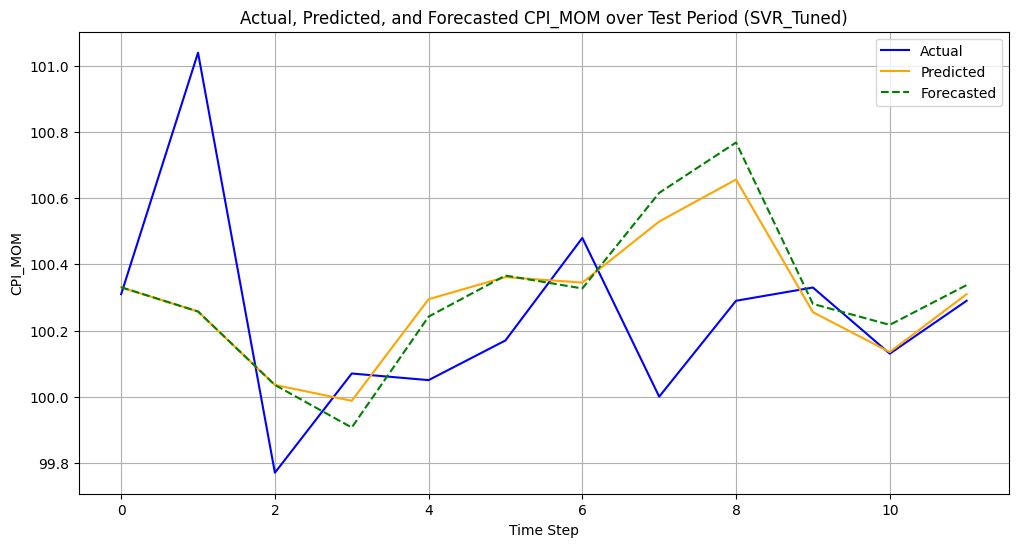

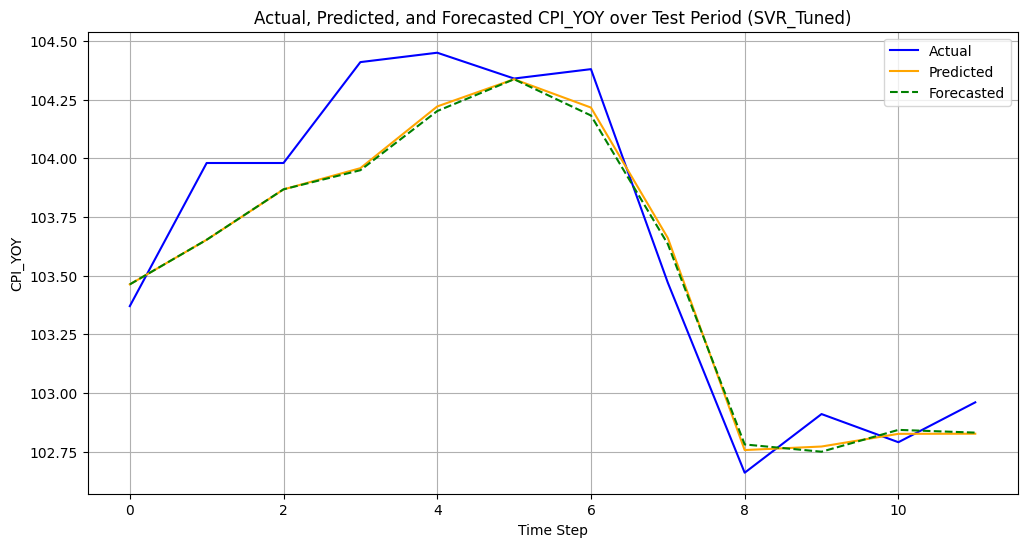


Forecast Results DataFrame for SVR_Tuned:
         time  cpi_mom_actual  cpi_mom_predicted  cpi_mom_forecasted  \
0  2024-01-01          100.31         100.330737          100.330737   
1  2024-02-01          101.04         100.257441          100.257444   
2  2024-03-01           99.77         100.035384          100.035342   
3  2024-04-01          100.07          99.987535           99.906729   
4  2024-05-01          100.05         100.294665          100.242075   
5  2024-06-01          100.17         100.361578          100.366247   
6  2024-07-01          100.48         100.344865          100.327206   
7  2024-08-01          100.00         100.529540          100.616268   
8  2024-09-01          100.29         100.656652          100.768536   
9  2024-10-01          100.33         100.255492          100.280416   
10 2024-11-01          100.13         100.134786          100.217104   
11 2024-12-01          100.29         100.310013          100.337403   

    cpi_yoy_actual  

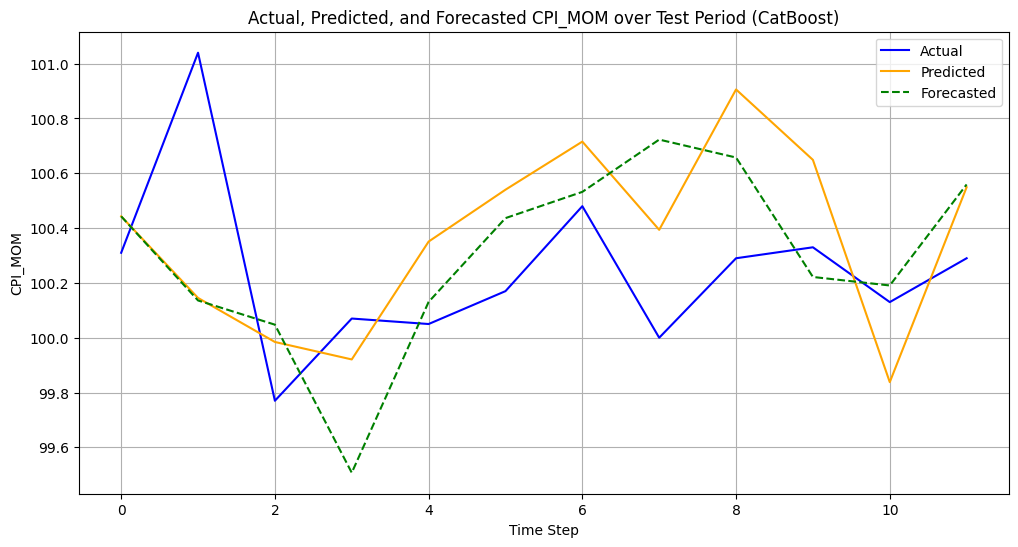

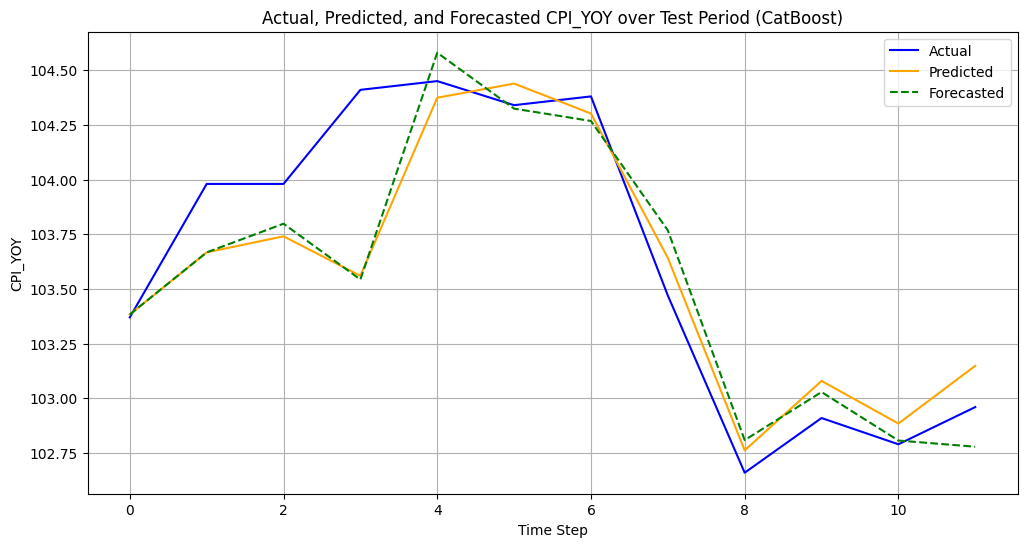


Forecast Results DataFrame for CatBoost:
         time  cpi_mom_actual  cpi_mom_predicted  cpi_mom_forecasted  \
0  2024-01-01          100.31         100.442987          100.442987   
1  2024-02-01          101.04         100.145212          100.135992   
2  2024-03-01           99.77          99.984514          100.047649   
3  2024-04-01          100.07          99.920776           99.507395   
4  2024-05-01          100.05         100.350831          100.130614   
5  2024-06-01          100.17         100.540143          100.436459   
6  2024-07-01          100.48         100.715658          100.532231   
7  2024-08-01          100.00         100.393744          100.723008   
8  2024-09-01          100.29         100.905971          100.657581   
9  2024-10-01          100.33         100.648992          100.221704   
10 2024-11-01          100.13          99.837954          100.190670   
11 2024-12-01          100.29         100.549159          100.559283   

    cpi_yoy_actual  c

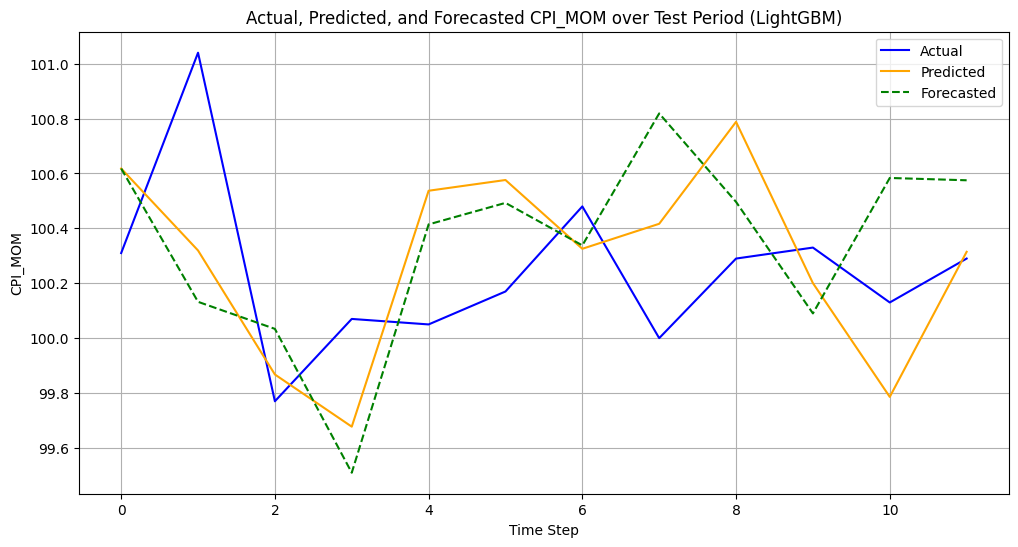

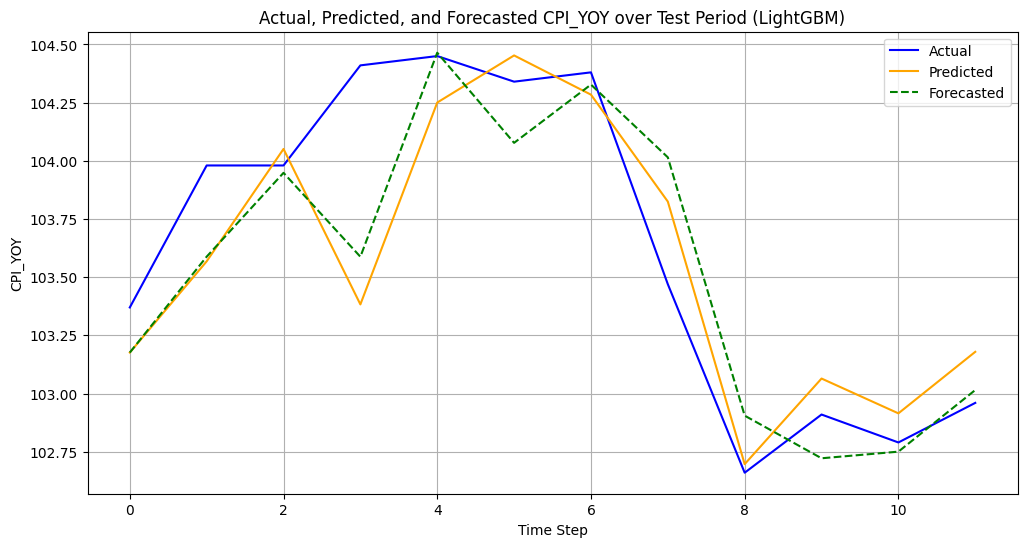


Forecast Results DataFrame for LightGBM:
         time  cpi_mom_actual  cpi_mom_predicted  cpi_mom_forecasted  \
0  2024-01-01          100.31         100.618034          100.618034   
1  2024-02-01          101.04         100.319467          100.132404   
2  2024-03-01           99.77          99.867619          100.033796   
3  2024-04-01          100.07          99.677423           99.509646   
4  2024-05-01          100.05         100.537101          100.414421   
5  2024-06-01          100.17         100.576224          100.492845   
6  2024-07-01          100.48         100.325604          100.337952   
7  2024-08-01          100.00         100.416677          100.818751   
8  2024-09-01          100.29         100.788072          100.496450   
9  2024-10-01          100.33         100.200506          100.090163   
10 2024-11-01          100.13          99.785970          100.583671   
11 2024-12-01          100.29         100.314503          100.575202   

    cpi_yoy_actual  c

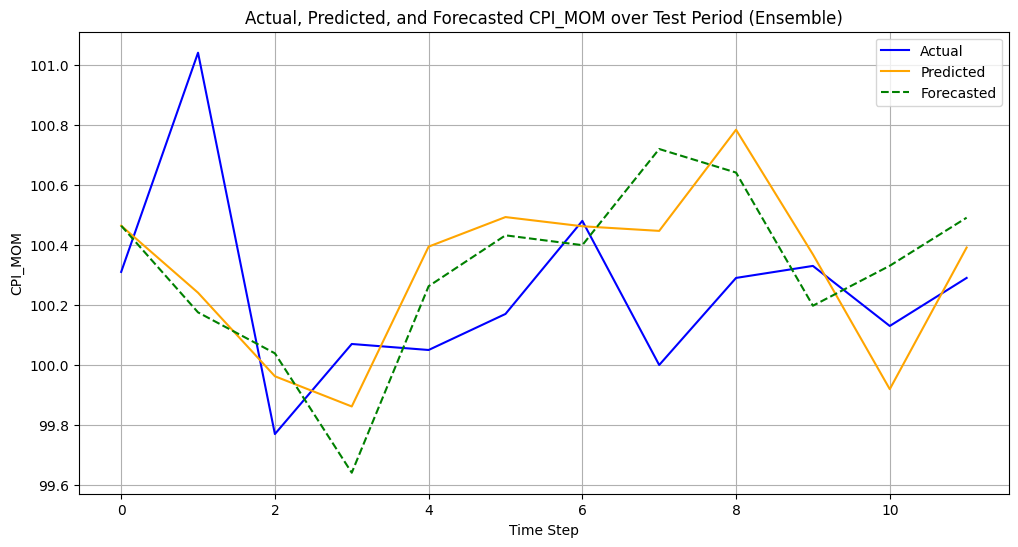

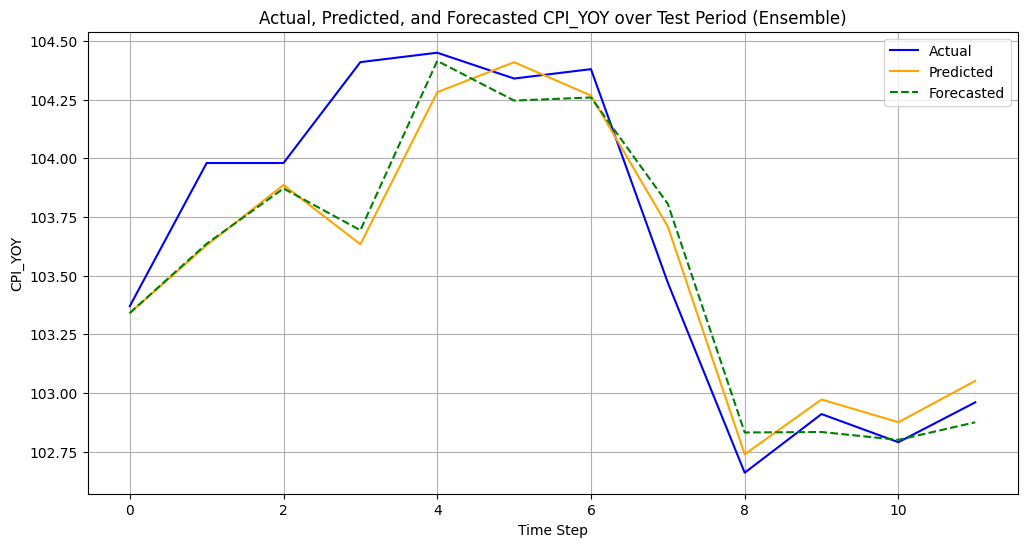


Forecast Results DataFrame for Ensemble:
         time  cpi_mom_actual  cpi_mom_predicted  cpi_mom_forecasted  \
0  2024-01-01          100.31         100.463919          100.463919   
1  2024-02-01          101.04         100.240707          100.175280   
2  2024-03-01           99.77          99.962506          100.038929   
3  2024-04-01          100.07          99.861911           99.641256   
4  2024-05-01          100.05         100.394199          100.262370   
5  2024-06-01          100.17         100.492648          100.431850   
6  2024-07-01          100.48         100.462042          100.399130   
7  2024-08-01          100.00         100.446654          100.719342   
8  2024-09-01          100.29         100.783565          100.640856   
9  2024-10-01          100.33         100.368330          100.197428   
10 2024-11-01          100.13          99.919570          100.330482   
11 2024-12-01          100.29         100.391225          100.490629   

    cpi_yoy_actual  c

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings("ignore")

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to create lagged features for residuals
def create_lagged_features(data, lags=12):
    df = pd.DataFrame()
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = data.shift(i)
    return df.dropna()

# Function to prepare LSTM input
def prepare_lstm_input(features, lags=12):
    X = []
    for i in range(len(features) - lags + 1):
        X.append(features[i:i+lags])
    return np.array(X)

# Load and preprocess data
data = pd.read_csv('data/analyzed_time_series.csv', index_col='time', parse_dates=['time'])
test_size = 12
train_size = len(data) - test_size
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Initialize results dictionary to store metrics
results = {
    'Model': [],
    'CPI_MOM_RMSE_Pred': [], 'CPI_MOM_MAE_Pred': [], 'CPI_MOM_MAPE_Pred': [],
    'CPI_MOM_RMSE_Forecast': [], 'CPI_MOM_MAE_Forecast': [], 'CPI_MOM_MAPE_Forecast': [],
    'CPI_YOY_RMSE_Pred': [], 'CPI_YOY_MAE_Pred': [], 'CPI_YOY_MAPE_Pred': [],
    'CPI_YOY_RMSE_Forecast': [], 'CPI_YOY_MAE_Forecast': [], 'CPI_YOY_MAPE_Forecast': []
}

# Function to train and evaluate hybrid model
def train_hybrid_model(model_name, model_mom, model_yoy, train_data, test_data, lags=12, scaler=None, is_lstm=False):
    # --- CPI_MOM (SARIMA + Model) ---
    cpi_mom_train = train_data['cpi_mom']
    sarima_mom_model = auto_arima(cpi_mom_train, seasonal=True, m=12, suppress_warnings=True)
    sarima_mom = SARIMAX(cpi_mom_train, order=sarima_mom_model.order, 
                         seasonal_order=sarima_mom_model.seasonal_order).fit(disp=False)

    # Calculate residuals
    residuals_mom = cpi_mom_train - sarima_mom.fittedvalues

    # Prepare lagged residuals
    residuals_df_mom = create_lagged_features(residuals_mom, lags)
    features_mom = residuals_df_mom
    target_mom = residuals_mom.loc[residuals_df_mom.index]

    # Scale features if scaler is provided
    if scaler:
        features_mom_scaled = scaler.fit_transform(features_mom)
        features_mom = pd.DataFrame(features_mom_scaled, index=features_mom.index, columns=features_mom.columns)
    else:
        features_mom_scaled = features_mom

    # Prepare LSTM input if applicable
    if is_lstm:
        X_mom = prepare_lstm_input(features_mom_scaled.values, lags)
        y_mom = target_mom.values[lags-1:]
        model_mom.fit(X_mom, y_mom, epochs=50, batch_size=8, verbose=0)
    else:
        model_mom.fit(features_mom_scaled, target_mom)

    # Predict on test set (using actual residuals)
    sarima_pred_mom_test = sarima_mom.forecast(steps=test_size)
    residuals_pred_mom_test = []
    last_residuals = residuals_mom.tail(lags).values[::-1]
    if scaler:
        last_residuals_scaled = scaler.transform(last_residuals.reshape(1, -1)).flatten()
    else:
        last_residuals_scaled = last_residuals
    for i in range(test_size):
        if is_lstm:
            input_data = last_residuals_scaled.reshape(1, lags, 1)
            pred_residual = model_mom.predict(input_data, verbose=0)[0][0]
        else:
            pred_residual = model_mom.predict([last_residuals_scaled])[0]
        residuals_pred_mom_test.append(pred_residual)
        if i < test_size - 1:
            actual_residual = test_data['cpi_mom'].iloc[i] - sarima_pred_mom_test.iloc[i]
            last_residuals = np.roll(last_residuals, -1)
            last_residuals[-1] = actual_residual
            if scaler:
                last_residuals_scaled = scaler.transform(last_residuals.reshape(1, -1)).flatten()
            else:
                last_residuals_scaled = last_residuals
    hybrid_pred_mom_test = sarima_pred_mom_test + np.array(residuals_pred_mom_test)

    # Forecast for test period (recursive, using predicted residuals)
    hybrid_forecast_mom = []
    last_residuals = residuals_mom.tail(lags).values[::-1]
    if scaler:
        last_residuals_scaled = scaler.transform(last_residuals.reshape(1, -1)).flatten()
    else:
        last_residuals_scaled = last_residuals
    for i in range(test_size):
        if is_lstm:
            input_data = last_residuals_scaled.reshape(1, lags, 1)
            forecast_residual = model_mom.predict(input_data, verbose=0)[0][0]
        else:
            forecast_residual = model_mom.predict([last_residuals_scaled])[0]
        total_forecast = sarima_pred_mom_test.iloc[i] + forecast_residual
        hybrid_forecast_mom.append(total_forecast)
        last_residuals = np.roll(last_residuals, -1)
        last_residuals[-1] = forecast_residual
        if scaler:
            last_residuals_scaled = scaler.transform(last_residuals.reshape(1, -1)).flatten()
        else:
            last_residuals_scaled = last_residuals

    # Evaluate CPI_MOM
    y_true_mom = test_data['cpi_mom'].values
    y_pred_mom = hybrid_pred_mom_test.values
    y_forecast_mom = np.array(hybrid_forecast_mom)
    rmse_mom_pred = np.sqrt(mean_squared_error(y_true_mom, y_pred_mom))
    mae_mom_pred = mean_absolute_error(y_true_mom, y_pred_mom)
    mape_mom_pred = mean_absolute_percentage_error(y_true_mom, y_pred_mom)
    rmse_mom_forecast = np.sqrt(mean_squared_error(y_true_mom, y_forecast_mom))
    mae_mom_forecast = mean_absolute_error(y_true_mom, y_forecast_mom)
    mape_mom_forecast = mean_absolute_percentage_error(y_true_mom, y_forecast_mom)

    # --- CPI_YOY (SARIMAX + Model) ---
    cpi_yoy_train = train_data['cpi_yoy']
    exog_train = train_data[['oil_price']] if 'oil_price' in train_data.columns else None
    exog_test = test_data[['oil_price']] if 'oil_price' in test_data.columns else None
    sarimax_yoy_model = auto_arima(cpi_yoy_train, exogenous=exog_train, seasonal=True, m=12, 
                                   suppress_warnings=True)
    sarimax_yoy = SARIMAX(cpi_yoy_train, order=sarimax_yoy_model.order, 
                          seasonal_order=sarimax_yoy_model.seasonal_order, 
                          exog=exog_train).fit(disp=False)

    # Calculate residuals
    residuals_yoy = cpi_yoy_train - sarimax_yoy.fittedvalues

    # Prepare lagged residuals
    residuals_df_yoy = create_lagged_features(residuals_yoy, lags)
    features_yoy = residuals_df_yoy
    target_yoy = residuals_yoy.loc[residuals_df_yoy.index]

    # Scale features if scaler is provided
    if scaler:
        features_yoy_scaled = scaler.fit_transform(features_yoy)
        features_yoy = pd.DataFrame(features_yoy_scaled, index=features_yoy.index, columns=features_yoy.columns)
    else:
        features_yoy_scaled = features_yoy

    # Prepare LSTM input if applicable
    if is_lstm:
        X_yoy = prepare_lstm_input(features_yoy_scaled.values, lags)
        y_yoy = target_yoy.values[lags-1:]
        model_yoy.fit(X_yoy, y_yoy, epochs=50, batch_size=8, verbose=0)
    else:
        model_yoy.fit(features_yoy_scaled, target_yoy)

    # Predict on test set (using actual residuals)
    sarimax_pred_yoy_test = sarimax_yoy.forecast(steps=test_size, exog=exog_test)
    residuals_pred_yoy_test = []
    last_residuals_yoy = residuals_yoy.tail(lags).values[::-1]
    if scaler:
        last_residuals_yoy_scaled = scaler.transform(last_residuals_yoy.reshape(1, -1)).flatten()
    else:
        last_residuals_yoy_scaled = last_residuals_yoy
    for i in range(test_size):
        if is_lstm:
            input_data = last_residuals_yoy_scaled.reshape(1, lags, 1)
            pred_residual = model_yoy.predict(input_data, verbose=0)[0][0]
        else:
            pred_residual = model_yoy.predict([last_residuals_yoy_scaled])[0]
        residuals_pred_yoy_test.append(pred_residual)
        if i < test_size - 1:
            actual_residual = test_data['cpi_yoy'].iloc[i] - sarimax_pred_yoy_test.iloc[i]
            last_residuals_yoy = np.roll(last_residuals_yoy, -1)
            last_residuals_yoy[-1] = actual_residual
            if scaler:
                last_residuals_yoy_scaled = scaler.transform(last_residuals_yoy.reshape(1, -1)).flatten()
            else:
                last_residuals_yoy_scaled = last_residuals_yoy
    hybrid_pred_yoy_test = sarimax_pred_yoy_test + np.array(residuals_pred_yoy_test)

    # Forecast for test period (recursive, using predicted residuals)
    hybrid_forecast_yoy = []
    last_residuals_yoy = residuals_yoy.tail(lags).values[::-1]
    if scaler:
        last_residuals_yoy_scaled = scaler.transform(last_residuals_yoy.reshape(1, -1)).flatten()
    else:
        last_residuals_yoy_scaled = last_residuals_yoy
    for i in range(test_size):
        if is_lstm:
            input_data = last_residuals_yoy_scaled.reshape(1, lags, 1)
            forecast_residual = model_yoy.predict(input_data, verbose=0)[0][0]
        else:
            forecast_residual = model_yoy.predict([last_residuals_yoy_scaled])[0]
        total_forecast = sarimax_pred_yoy_test.iloc[i] + forecast_residual
        hybrid_forecast_yoy.append(total_forecast)
        last_residuals_yoy = np.roll(last_residuals_yoy, -1)
        last_residuals_yoy[-1] = forecast_residual
        if scaler:
            last_residuals_yoy_scaled = scaler.transform(last_residuals_yoy.reshape(1, -1)).flatten()
        else:
            last_residuals_yoy_scaled = last_residuals_yoy

    # Evaluate CPI_YOY
    y_true_yoy = test_data['cpi_yoy'].values
    y_pred_yoy = hybrid_pred_yoy_test.values
    y_forecast_yoy = np.array(hybrid_forecast_yoy)
    rmse_yoy_pred = np.sqrt(mean_squared_error(y_true_yoy, y_pred_yoy))
    mae_yoy_pred = mean_absolute_error(y_true_yoy, y_pred_yoy)
    mape_yoy_pred = mean_absolute_percentage_error(y_true_yoy, y_pred_yoy)
    rmse_yoy_forecast = np.sqrt(mean_squared_error(y_true_yoy, y_forecast_yoy))
    mae_yoy_forecast = mean_absolute_error(y_true_yoy, y_forecast_yoy)
    mape_yoy_forecast = mean_absolute_percentage_error(y_true_yoy, y_forecast_yoy)

    # Store results
    results['Model'].append(model_name)
    results['CPI_MOM_RMSE_Pred'].append(rmse_mom_pred)
    results['CPI_MOM_MAE_Pred'].append(mae_mom_pred)
    results['CPI_MOM_MAPE_Pred'].append(mape_mom_pred)
    results['CPI_MOM_RMSE_Forecast'].append(rmse_mom_forecast)
    results['CPI_MOM_MAE_Forecast'].append(mae_mom_forecast)
    results['CPI_MOM_MAPE_Forecast'].append(mape_mom_forecast)
    results['CPI_YOY_RMSE_Pred'].append(rmse_yoy_pred)
    results['CPI_YOY_MAE_Pred'].append(mae_yoy_pred)
    results['CPI_YOY_MAPE_Pred'].append(mape_yoy_pred)
    results['CPI_YOY_RMSE_Forecast'].append(rmse_yoy_forecast)
    results['CPI_YOY_MAE_Forecast'].append(mae_yoy_forecast)
    results['CPI_YOY_MAPE_Forecast'].append(mape_yoy_forecast)

    # Save forecast results
    forecast_df = pd.DataFrame({
        'time': test_data.index,
        'cpi_mom_actual': y_true_mom,
        'cpi_mom_predicted': y_pred_mom,
        'cpi_mom_forecasted': y_forecast_mom,
        'cpi_yoy_actual': y_true_yoy,
        'cpi_yoy_predicted': y_pred_yoy,
        'cpi_yoy_forecasted': y_forecast_yoy
    })
    forecast_df.to_csv(f'plots/cpi_forecast_results_{model_name.lower()}.csv', index=False)

    # Plot results
    def plot_results(y_test, predictions, forecasts, test_size=12, title="CPI"):
        plt.figure(figsize=(12, 6))
        plt.plot(range(test_size), y_test, label='Actual', color='blue')
        plt.plot(range(test_size), predictions, label='Predicted', color='orange')
        plt.plot(range(test_size), forecasts, label='Forecasted', color='green', linestyle='--')
        plt.title(f'Actual, Predicted, and Forecasted {title} over Test Period ({model_name})')
        plt.xlabel('Time Step')
        plt.ylabel(title)
        plt.legend()
        plt.grid(True)
        plt.savefig(f'plots/{title.lower()}_test_period_plot_{model_name.lower()}.png')
        plt.show()

    plot_results(y_true_mom, y_pred_mom, y_forecast_mom, test_size, title='CPI_MOM')
    plot_results(y_true_yoy, y_pred_yoy, y_forecast_yoy, test_size, title='CPI_YOY')

    return forecast_df, hybrid_pred_mom_test, hybrid_forecast_mom, hybrid_pred_yoy_test, hybrid_forecast_yoy

# Ensemble model function
def ensemble_predictions(predictions_dict, model_names, y_true_mom, y_true_yoy, test_data, test_size=12):
    # Average predictions and forecasts
    pred_mom = np.mean([predictions_dict[model]['pred_mom'] for model in model_names], axis=0)
    forecast_mom = np.mean([predictions_dict[model]['forecast_mom'] for model in model_names], axis=0)
    pred_yoy = np.mean([predictions_dict[model]['pred_yoy'] for model in model_names], axis=0)
    forecast_yoy = np.mean([predictions_dict[model]['forecast_yoy'] for model in model_names], axis=0)

    # Evaluate CPI_MOM
    rmse_mom_pred = np.sqrt(mean_squared_error(y_true_mom, pred_mom))
    mae_mom_pred = mean_absolute_error(y_true_mom, pred_mom)
    mape_mom_pred = mean_absolute_percentage_error(y_true_mom, pred_mom)
    rmse_mom_forecast = np.sqrt(mean_squared_error(y_true_mom, forecast_mom))
    mae_mom_forecast = mean_absolute_error(y_true_mom, forecast_mom)
    mape_mom_forecast = mean_absolute_percentage_error(y_true_mom, forecast_mom)

    # Evaluate CPI_YOY
    rmse_yoy_pred = np.sqrt(mean_squared_error(y_true_yoy, pred_yoy))
    mae_yoy_pred = mean_absolute_error(y_true_yoy, pred_yoy)
    mape_yoy_pred = mean_absolute_percentage_error(y_true_yoy, pred_yoy)
    rmse_yoy_forecast = np.sqrt(mean_squared_error(y_true_yoy, forecast_yoy))
    mae_yoy_forecast = mean_absolute_error(y_true_yoy, forecast_yoy)
    mape_yoy_forecast = mean_absolute_percentage_error(y_true_yoy, forecast_yoy)

    # Store results
    results['Model'].append('Ensemble')
    results['CPI_MOM_RMSE_Pred'].append(rmse_mom_pred)
    results['CPI_MOM_MAE_Pred'].append(mae_mom_pred)
    results['CPI_MOM_MAPE_Pred'].append(mape_mom_pred)
    results['CPI_MOM_RMSE_Forecast'].append(rmse_mom_forecast)
    results['CPI_MOM_MAE_Forecast'].append(mae_mom_forecast)
    results['CPI_MOM_MAPE_Forecast'].append(mape_mom_forecast)
    results['CPI_YOY_RMSE_Pred'].append(rmse_yoy_pred)
    results['CPI_YOY_MAE_Pred'].append(mae_yoy_pred)
    results['CPI_YOY_MAPE_Pred'].append(mape_yoy_pred)
    results['CPI_YOY_RMSE_Forecast'].append(rmse_yoy_forecast)
    results['CPI_YOY_MAE_Forecast'].append(mae_yoy_forecast)
    results['CPI_YOY_MAPE_Forecast'].append(mape_yoy_forecast)

    # Save forecast results
    forecast_df = pd.DataFrame({
        'time': test_data.index,
        'cpi_mom_actual': y_true_mom,
        'cpi_mom_predicted': pred_mom,
        'cpi_mom_forecasted': forecast_mom,
        'cpi_yoy_actual': y_true_yoy,
        'cpi_yoy_predicted': pred_yoy,
        'cpi_yoy_forecasted': forecast_yoy
    })
    forecast_df.to_csv('plots/cpi_forecast_results_ensemble.csv', index=False)

    # Plot results
    def plot_results(y_test, predictions, forecasts, test_size=12, title="CPI"):
        plt.figure(figsize=(12, 6))
        plt.plot(range(test_size), y_test, label='Actual', color='blue')
        plt.plot(range(test_size), predictions, label='Predicted', color='orange')
        plt.plot(range(test_size), forecasts, label='Forecasted', color='green', linestyle='--')
        plt.title(f'Actual, Predicted, and Forecasted {title} over Test Period (Ensemble)')
        plt.xlabel('Time Step')
        plt.ylabel(title)
        plt.legend()
        plt.grid(True)
        plt.savefig(f'plots/{title.lower()}_test_period_plot_ensemble.png')
        plt.show()

    plot_results(y_true_mom, pred_mom, forecast_mom, test_size, title='CPI_MOM')
    plot_results(y_true_yoy, pred_yoy, forecast_yoy, test_size, title='CPI_YOY')

    return forecast_df

# Define models to test
scaler = StandardScaler()
param_grid_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'gamma': ['scale', 'auto', 0.1]
}
svr_mom = GridSearchCV(SVR(kernel='rbf'), param_grid_svr, cv=5, scoring='neg_mean_squared_error')
svr_yoy = GridSearchCV(SVR(kernel='rbf'), param_grid_svr, cv=5, scoring='neg_mean_squared_error')

lstm_mom = Sequential([
    LSTM(50, input_shape=(12, 1), return_sequences=False),
    Dense(1)
])
lstm_mom.compile(optimizer='adam', loss='mse')
lstm_yoy = Sequential([
    LSTM(50, input_shape=(12, 1), return_sequences=False),
    Dense(1)
])
lstm_yoy.compile(optimizer='adam', loss='mse')

models = [
    {
        'name': 'SVR_Tuned',
        'model_mom': svr_mom,
        'model_yoy': svr_yoy,
        'scaler': scaler,
        'is_lstm': False
    },
    {
        'name': 'CatBoost',
        'model_mom': CatBoostRegressor(n_estimators=100, random_state=42, verbose=0),
        'model_yoy': CatBoostRegressor(n_estimators=100, random_state=42, verbose=0),
        'scaler': None,
        'is_lstm': False
    },
    # {
    #     'name': 'LSTM',
    #     'model_mom': lstm_mom,
    #     'model_yoy': lstm_yoy,
    #     'scaler': scaler,
    #     'is_lstm': True
    # },
    {
        'name': 'LightGBM',
        'model_mom': LGBMRegressor(n_estimators=100, random_state=42),
        'model_yoy': LGBMRegressor(n_estimators=100, random_state=42),
        'scaler': None,
        'is_lstm': False
    }
]

# Store predictions for ensemble
predictions_dict = {}

# Run experiments for each model
for model_config in models:
    print(f"\nRunning Hybrid Model: {model_config['name']}")
    forecast_df, pred_mom, forecast_mom, pred_yoy, forecast_yoy = train_hybrid_model(
        model_name=model_config['name'],
        model_mom=model_config['model_mom'],
        model_yoy=model_config['model_yoy'],
        train_data=train,
        test_data=test,
        lags=12,
        scaler=model_config['scaler'],
        is_lstm=model_config['is_lstm']
    )
    print(f"\nForecast Results DataFrame for {model_config['name']}:")
    print(forecast_df)
    predictions_dict[model_config['name']] = {
        'pred_mom': pred_mom,
        'forecast_mom': forecast_mom,
        'pred_yoy': pred_yoy,
        'forecast_yoy': forecast_yoy
    }
    if model_config['name'] == 'SVR_Tuned':
        print(f"Best parameters for SVR (CPI MOM): {svr_mom.best_params_}")
        print(f"Best parameters for SVR (CPI YOY): {svr_yoy.best_params_}")

# Run ensemble model
print("\nRunning Ensemble Model")
ensemble_df = ensemble_predictions(
    predictions_dict,
    model_names=['SVR_Tuned', 'LightGBM', 'CatBoost'],
    y_true_mom=test['cpi_mom'].values,
    y_true_yoy=test['cpi_yoy'].values,
    test_data=test,
    test_size=12
)
print("\nForecast Results DataFrame for Ensemble:")
print(ensemble_df)

# Add baseline results (Random Forest + Ridge and XGBoost)
results['Model'].extend(['RandomForest_Ridge', 'XGBoost'])
results['CPI_MOM_RMSE_Pred'].extend([0.3741, None])
results['CPI_MOM_MAE_Pred'].extend([0.2971, None])
results['CPI_MOM_MAPE_Pred'].extend([0.30, None])
results['CPI_MOM_RMSE_Forecast'].extend([0.3932, None])
results['CPI_MOM_MAE_Forecast'].extend([0.3107, None])
results['CPI_MOM_MAPE_Forecast'].extend([0.31, None])
results['CPI_YOY_RMSE_Pred'].extend([0.2273, None])
results['CPI_YOY_MAE_Pred'].extend([0.1864, None])
results['CPI_YOY_MAPE_Pred'].extend([0.18, None])
results['CPI_YOY_RMSE_Forecast'].extend([0.2340, None])
results['CPI_YOY_MAE_Forecast'].extend([0.1867, None])
results['CPI_YOY_MAPE_Forecast'].extend([0.18, None])

# Display comparison of results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# Save comparison to CSV
results_df.to_csv('plots/model_comparison_results_improved.csv', index=False)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform, randint
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from borutapy import BorutaPy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from arch import arch_model
import os
import logging
from statsmodels.tsa.stattools import adfuller

# Setup logging
logging.basicConfig(
    filename='ml_forecaster_log.txt',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Debug logging for metrics
debug_logger = logging.getLogger('debug_metrics')
debug_handler = logging.FileHandler('ml_metrics_debug.txt')
debug_handler.setFormatter(logging.Formatter('%(asctime)s - %(message)s'))
debug_logger.addHandler(debug_handler)
debug_logger.setLevel(logging.DEBUG)

# Configuration
CONFIG = {
    'forecast_horizon': 12,
    'lags': list(range(1, 13)),
    'test_size': 12,
    'results_file': 'ml_forecast_results.csv',
    'plot_dir': 'ml_plots',
    'n_bootstrap': 200,
    'n_iter_search': 30,
    'cv_folds': 5,
    'epsilon': 1e-3,
    'rolling_window': 3,
    'fourier_periods': [12, 6],
    'recursive_horizon': 3,
    'lstm_sequence_length': 12,
    'lstm_epochs': 50,
    'lstm_batch_size': 32,
}

# Create plot directory
os.makedirs(CONFIG['plot_dir'], exist_ok=True)

class MLForecaster:
    def __init__(self, data_path, target_col, model_type='linear', lags=CONFIG['lags'], 
                 random_search=False, use_exogenous=True, use_seasonal=True):
        self.data_path = data_path
        self.target_col = target_col
        self.lags = lags
        self.model_type = model_type.lower()
        self.random_search = random_search
        self.use_exogenous = use_exogenous
        self.use_seasonal = use_seasonal
        self.df = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None
        self.feature_names = None
        self.X_train = self.X_test = self.y_train = self.y_test = None
        self.results = {}
        self.is_differenced = False
        self.original_last_value = None
        self.selected_features = None
        self.ensemble_weights = None

    def validate_data(self):
        """Validate input data for missing values, duplicates, and sufficient length."""
        required_columns = [self.target_col]
        if self.use_exogenous and self.target_col == 'cpi_yoy':
            required_columns.append('cpi_mom')
        if not all(col in self.df.columns for col in required_columns):
            raise ValueError(f"Missing required columns: {required_columns}")
        if self.df.index.duplicated().any():
            raise ValueError("Duplicate index values found!")
        if not self.df.index.is_monotonic_increasing:
            raise ValueError("Index is not monotonically increasing!")
        if self.df[self.target_col].isnull().sum() > 0:
            raise ValueError(f"Missing values in {self.target_col}: {self.df[self.target_col].isnull().sum()}")
        if len(self.df) < self.lags[-1] + CONFIG['test_size'] + CONFIG['forecast_horizon']:
            raise ValueError(f"Data length ({len(self.df)}) too short for lags ({self.lags[-1]}), test_size ({CONFIG['test_size']}), and forecast_horizon ({CONFIG['forecast_horizon']})")
        # Check stationarity
        result = adfuller(self.df[self.target_col].dropna())
        logger.info(f"ADF Test for {self.target_col}: Statistic={result[0]:.4f}, p-value={result[1]:.4f}")
        if result[1] > 0.05:
            logger.warning(f"{self.target_col} may not be stationary (p-value={result[1]:.4f})")
            self.df['original_target'] = self.df[self.target_col].copy()
            self.df[self.target_col] = self.df[self.target_col].diff().dropna()
            self.is_differenced = True
            result = adfuller(self.df[self.target_col].dropna())
            if result[1] > 0.05:
                self.df[self.target_col] = self.df[self.target_col].diff().dropna()
                logger.info(f"Applied second-order differencing to {self.target_col}")
            logger.info(f"Applied differencing to {self.target_col}")

    def load_data(self):
        """Load and preprocess data with lagged, seasonal, exogenous, rolling, and Fourier features."""
        try:
            self.df = pd.read_csv(self.data_path, parse_dates=['time'], index_col='time')
            logger.info(f"Loaded data from {self.data_path} with shape {self.df.shape}")
            self.validate_data()
            
            # Standardize target
            self.df[self.target_col] = self.scaler.fit_transform(self.df[[self.target_col]].values)
            
            # Lagged features
            self.feature_names = [f'lag_{lag}' for lag in self.lags]
            for lag in self.lags:
                self.df[f'lag_{lag}'] = self.df[self.target_col].shift(lag)
            
            # Lagged differences
            self.df['lag1_diff'] = self.df['lag_1'].diff()
            self.feature_names.append('lag1_diff')
            
            # Seasonal features
            if self.use_seasonal:
                self.df['month'] = self.df.index.month
                self.df['quarter'] = self.df.index.quarter
                self.feature_names.extend(['month', 'quarter'])
                t = np.arange(len(self.df))
                for period in CONFIG['fourier_periods']:
                    self.df[f'sin_{period}'] = np.sin(2 * np.pi * t / period)
                    self.df[f'cos_{period}'] = np.cos(2 * np.pi * t / period)
                    self.feature_names.extend([f'sin_{period}', f'cos_{period}'])
            
            # Exogenous features
            if self.use_exogenous and self.target_col == 'cpi_yoy' and 'cpi_mom' in self.df.columns:
                self.df['cpi_mom_scaled'] = MinMaxScaler().fit_transform(self.df[['cpi_mom']].values)
                self.df['cpi_mom_lag1'] = self.df['cpi_mom_scaled'].shift(1)
                self.feature_names.extend(['cpi_mom_scaled', 'cpi_mom_lag1'])
            
            # Rolling statistics
            self.df['rolling_mean'] = self.df[self.target_col].shift(1).rolling(CONFIG['rolling_window']).mean()
            self.df['rolling_std'] = self.df[self.target_col].shift(1).rolling(CONFIG['rolling_window']).std()
            self.feature_names.extend(['rolling_mean', 'rolling_std'])
            
            # Volatility (GARCH)
            returns = self.df[self.target_col].diff().dropna()
            if len(returns) > 10:
                garch = arch_model(returns, vol='Garch', p=1, q=1, rescale=False).fit(disp='off')
                self.df['volatility'] = np.nan
                self.df['volatility'].iloc[-len(garch.conditional_volatility):] = garch.conditional_volatility
                self.feature_names.append('volatility')
            
            # Trend feature
            self.df['trend'] = np.linspace(0, 1, len(self.df))
            self.feature_names.append('trend')
            
            self.df.dropna(inplace=True)
            self.original_last_value = self.df['original_target'].iloc[-1] if self.is_differenced else None
            logger.info(f"Data after feature engineering and dropping NaN: shape {self.df.shape}")
        except Exception as e:
            logger.error(f"Error loading data: {str(e)}")
            raise

    def apply_boruta(self, X, y):
        """Apply Boruta feature selection for tree-based models."""
        try:
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
            boruta.fit(X.values, y.values)
            selected = X.columns[boruta.support_].tolist()
            logger.info(f"Boruta selected features: {selected}")
            return selected
        except Exception as e:
            logger.error(f"Error in Boruta feature selection: {str(e)}")
            return X.columns.tolist()

    def prepare_data(self):
        """Split data into train and test sets, apply Boruta for tree-based models."""
        try:
            X = self.df[self.feature_names]
            y = self.df[self.target_col]
            if self.model_type in ['random_forest', 'gradient_boosting', 'xgboost', 'lightgbm']:
                self.selected_features = self.apply_boruta(X, y)
                X = X[self.selected_features]
            self.X_train, self.X_test = X[:-CONFIG['test_size']], X[-CONFIG['test_size']:]
            self.y_train, self.y_test = y[:-CONFIG['test_size']], y[-CONFIG['test_size']:]
            logger.info(f"Train shape: X={self.X_train.shape}, y={self.y_train.shape}")
            logger.info(f"Test shape: X={self.X_test.shape}, y={self.y_test.shape}")
        except Exception as e:
            logger.error(f"Error preparing data: {str(e)}")
            raise

    def build_lstm_model(self, n_units=50, n_layers=1, dropout_rate=0.2):
        """Build LSTM model with specified architecture."""
        model = Sequential()
        for i in range(n_layers):
            if i == 0:
                model.add(LSTM(n_units, return_sequences=(n_layers > 1), input_shape=(CONFIG['lstm_sequence_length'], 1)))
            else:
                model.add(LSTM(n_units, return_sequences=(i < n_layers-1)))
            model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        return model

    def build_gru_model(self, n_units=50, n_layers=1, dropout_rate=0.2):
        """Build GRU model with specified architecture."""
        model = Sequential()
        for i in range(n_layers):
            if i == 0:
                model.add(GRU(n_units, return_sequences=(n_layers > 1), input_shape=(CONFIG['lstm_sequence_length'], 1)))
            else:
                model.add(GRU(n_units, return_sequences=(i < n_layers-1)))
            model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        return model

    def build_transformer_model(self, n_units=50, n_heads=4, dropout_rate=0.2):
        """Build Transformer model with specified architecture."""
        inputs = Input(shape=(CONFIG['lstm_sequence_length'], 1))
        x = MultiHeadAttention(num_heads=n_heads, key_dim=n_units // n_heads)(inputs, inputs)
        x = Dropout(dropout_rate)(x)
        x = LayerNormalization(epsilon=1e-6)(x + inputs)
        x = Dense(n_units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
        x = Dense(1)(x)
        outputs = x[:, -1, :]  # Take the last time step
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        return model

    def build_mlp_model(self, n_units=50, n_layers=2, dropout_rate=0.2):
        """Build MLP model with specified architecture."""
        model = Sequential()
        model.add(Dense(n_units, activation='relu', input_shape=(len(self.feature_names),)))
        for _ in range(n_layers - 1):
            model.add(Dense(n_units, activation='relu'))
            model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        return model

    def build_seq2seq_model(self, n_units=50, n_layers=1, dropout_rate=0.2):
        """Build Seq2Seq model with LSTM encoder-decoder architecture."""
        encoder_inputs = Input(shape=(CONFIG['lstm_sequence_length'], 1))
        encoder = LSTM(n_units, return_state=True)
        encoder_outputs, state_h, state_c = encoder(encoder_inputs)
        encoder_states = [state_h, state_c]
        
        decoder_inputs = Input(shape=(CONFIG['forecast_horizon'], 1))
        decoder_lstm = LSTM(n_units, return_sequences=True)
        decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(1)
        decoder_outputs = decoder_dense(decoder_outputs)
        
        model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        return model

    def prepare_lstm_data(self, X, y):
        """Prepare sequences for LSTM, GRU, Transformer, or Seq2Seq."""
        sequences = []
        targets = []
        for i in range(len(X) - CONFIG['lstm_sequence_length']):
            sequences.append(X[i:i+CONFIG['lstm_sequence_length']].values)
            if self.model_type == 'seq2seq':
                targets.append(y.iloc[i+1:i+1+CONFIG['forecast_horizon']].values.reshape(-1, 1))
            else:
                targets.append(y.iloc[i+CONFIG['lstm_sequence_length']])
        sequences = np.array(sequences)
        targets = np.array(targets)
        if self.model_type == 'seq2seq':
            decoder_inputs = np.zeros((len(targets), CONFIG['forecast_horizon'], 1))
            return sequences, decoder_inputs, targets
        return sequences, targets

    def build_model(self):
        """Build the specified model with hyperparameter tuning."""
        try:
            if self.model_type == 'linear':
                model = LinearRegression()
            elif self.model_type == 'ridge':
                if self.random_search:
                    param_dist = {'alpha': uniform(0.01, 500)}
                    model = RandomizedSearchCV(Ridge(), param_distributions=param_dist, n_iter=CONFIG['n_iter_search'], 
                                              scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']), 
                                              random_state=42)
                else:
                    param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 500]}
                    model = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', 
                                        cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']))
            elif self.model_type == 'lasso':
                if self.random_search:
                    param_dist = {'alpha': uniform(0.001, 1)}
                    model = RandomizedSearchCV(Lasso(max_iter=10000), param_distributions=param_dist, n_iter=CONFIG['n_iter_search'],
                                              scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']), 
                                              random_state=42)
                else:
                    param_grid = {'alpha': [0.001, 0.01, 0.1, 1]}
                    model = GridSearchCV(Lasso(max_iter=10000), param_grid, scoring='neg_mean_squared_error', 
                                        cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']))
            elif self.model_type == 'elasticnet':
                if self.random_search:
                    param_dist = {'alpha': uniform(0.001, 1), 'l1_ratio': uniform(0.1, 0.9)}
                    model = RandomizedSearchCV(ElasticNet(max_iter=10000), param_distributions=param_dist, n_iter=CONFIG['n_iter_search'],
                                              scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']), 
                                              random_state=42)
                else:
                    param_grid = {'alpha': [0.001, 0.01, 0.1, 1], 'l1_ratio': [0.1, 0.5, 0.9]}
                    model = GridSearchCV(ElasticNet(max_iter=10000), param_grid, scoring='neg_mean_squared_error', 
                                        cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']))
            elif self.model_type == 'svr':
                if self.random_search:
                    param_dist = {
                        'C': uniform(0.1, 100),
                        'epsilon': uniform(0.01, 1),
                        'kernel': ['linear', 'rbf'],
                    }
                    model = RandomizedSearchCV(SVR(), param_distributions=param_dist, n_iter=CONFIG['n_iter_search'],
                                              scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']), 
                                              random_state=42)
                else:
                    param_grid = {
                        'C': [0.1, 1, 10, 100],
                        'epsilon': [0.01, 0.1, 0.5],
                        'kernel': ['linear', 'rbf']
                    }
                    model = GridSearchCV(SVR(), param_grid, scoring='neg_mean_squared_error', 
                                        cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']))
            elif self.model_type == 'random_forest':
                if self.random_search:
                    param_dist = {
                        'n_estimators': randint(100, 500),
                        'max_depth': [None, 10, 20, 30],
                        'min_samples_split': randint(2, 10)
                    }
                    model = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=param_dist, 
                                              n_iter=CONFIG['n_iter_search'], scoring='neg_mean_squared_error', 
                                              cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']), random_state=42)
                else:
                    param_grid = {
                        'n_estimators': [100, 200, 300],
                        'max_depth': [None, 10, 20],
                        'min_samples_split': [2, 5, 10]
                    }
                    model = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, 
                                        scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']))
            elif self.model_type == 'gradient_boosting':
                if self.random_search:
                    param_dist = {
                        'n_estimators': randint(100, 500),
                        'learning_rate': uniform(0.01, 0.2),
                        'max_depth': randint(3, 8)
                    }
                    model = RandomizedSearchCV(GradientBoostingRegressor(random_state=42), param_distributions=param_dist, 
                                              n_iter=CONFIG['n_iter_search'], scoring='neg_mean_squared_error', 
                                              cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']), random_state=42)
                else:
                    param_grid = {
                        'n_estimators': [100, 200, 300],
                        'learning_rate': [0.01, 0.1, 0.2],
                        'max_depth': [3, 5, 7]
                    }
                    model = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, 
                                        scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']))
            elif self.model_type == 'xgboost':
                if self.random_search:
                    param_dist = {
                        'n_estimators': randint(100, 500),
                        'learning_rate': uniform(0.01, 0.2),
                        'max_depth': randint(3, 8),
                        'subsample': uniform(0.5, 0.5),
                        'colsample_bytree': uniform(0.5, 0.5)
                    }
                    model = RandomizedSearchCV(XGBRegressor(random_state=42, objective='reg:squarederror', 
                                                          early_stopping_rounds=10), 
                                              param_distributions=param_dist, n_iter=CONFIG['n_iter_search'], 
                                              scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']), 
                                              random_state=42)
                else:
                    param_grid = {
                        'n_estimators': [100, 200, 300],
                        'learning_rate': [0.01, 0.1, 0.2],
                        'max_depth': [3, 5, 7],
                        'subsample': [0.8, 1.0],
                        'colsample_bytree': [0.8, 1.0]
                    }
                    model = GridSearchCV(XGBRegressor(random_state=42, objective='reg:squarederror', 
                                                     early_stopping_rounds=10), 
                                        param_grid, scoring='neg_mean_squared_error', 
                                        cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']))
            elif self.model_type == 'lightgbm':
                if self.random_search:
                    param_dist = {
                        'n_estimators': randint(100, 500),
                        'learning_rate': uniform(0.01, 0.2),
                        'max_depth': randint(3, 8),
                        'num_leaves': randint(20, 50),
                        'subsample': uniform(0.5, 0.5)
                    }
                    model = RandomizedSearchCV(LGBMRegressor(random_state=42, verbose=-1, early_stopping_rounds=10), 
                                              param_distributions=param_dist, n_iter=CONFIG['n_iter_search'], 
                                              scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']), 
                                              random_state=42)
                else:
                    param_grid = {
                        'n_estimators': [100, 200, 300],
                        'learning_rate': [0.01, 0.1, 0.2],
                        'max_depth': [3, 5, 7],
                        'num_leaves': [20, 31, 50],
                        'subsample': [0.8, 1.0]
                    }
                    model = GridSearchCV(LGBMRegressor(random_state=42, verbose=-1, early_stopping_rounds=10), 
                                        param_grid, scoring='neg_mean_squared_error', 
                                        cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']))
            elif self.model_type == 'lstm':
                param_grid = {
                    'n_units': [50, 100],
                    'n_layers': [1, 2],
                    'dropout_rate': [0.2, 0.3]
                }
                best_score = float('inf')
                best_model = None
                best_params = {}
                for n_units in param_grid['n_units']:
                    for n_layers in param_grid['n_layers']:
                        for dropout_rate in param_grid['dropout_rate']:
                            model = self.build_lstm_model(n_units, n_layers, dropout_rate)
                            X_seq, y_seq = self.prepare_lstm_data(self.X_train, self.y_train)
                            if len(X_seq) == 0:
                                logger.warning("Insufficient data for LSTM sequences")
                                continue
                            scores = []
                            tscv = TimeSeriesSplit(n_splits=CONFIG['cv_folds'])
                            for train_idx, val_idx in tscv.split(X_seq):
                                X_tr, X_val = X_seq[train_idx], X_seq[val_idx]
                                y_tr, y_val = y_seq[train_idx], y_seq[val_idx]
                                model.fit(X_tr, y_tr, epochs=CONFIG['lstm_epochs'], batch_size=CONFIG['lstm_batch_size'], 
                                         verbose=0, validation_data=(X_val, y_val))
                                y_pred = model.predict(X_val, verbose=0)
                                score = mean_squared_error(y_val, y_pred)
                                scores.append(score)
                            mean_score = np.mean(scores)
                            if mean_score < best_score:
                                best_score = mean_score
                                best_model = model
                                best_params = {'n_units': n_units, 'n_layers': n_layers, 'dropout_rate': dropout_rate}
                logger.info(f"Best LSTM params: {best_params}, score: {best_score}")
                model = best_model
            elif self.model_type == 'gru':
                param_grid = {
                    'n_units': [50, 100],
                    'n_layers': [1, 2],
                    'dropout_rate': [0.2, 0.3]
                }
                best_score = float('inf')
                best_model = None
                best_params = {}
                for n_units in param_grid['n_units']:
                    for n_layers in param_grid['n_layers']:
                        for dropout_rate in param_grid['dropout_rate']:
                            model = self.build_gru_model(n_units, n_layers, dropout_rate)
                            X_seq, y_seq = self.prepare_lstm_data(self.X_train, self.y_train)
                            if len(X_seq) == 0:
                                logger.warning("Insufficient data for GRU sequences")
                                continue
                            scores = []
                            tscv = TimeSeriesSplit(n_splits=CONFIG['cv_folds'])
                            for train_idx, val_idx in tscv.split(X_seq):
                                X_tr, X_val = X_seq[train_idx], X_seq[val_idx]
                                y_tr, y_val = y_seq[train_idx], y_seq[val_idx]
                                model.fit(X_tr, y_tr, epochs=CONFIG['lstm_epochs'], batch_size=CONFIG['lstm_batch_size'], 
                                         verbose=0, validation_data=(X_val, y_val))
                                y_pred = model.predict(X_val, verbose=0)
                                score = mean_squared_error(y_val, y_pred)
                                scores.append(score)
                            mean_score = np.mean(scores)
                            if mean_score < best_score:
                                best_score = mean_score
                                best_model = model
                                best_params = {'n_units': n_units, 'n_layers': n_layers, 'dropout_rate': dropout_rate}
                logger.info(f"Best GRU params: {best_params}, score: {best_score}")
                model = best_model
            elif self.model_type == 'transformer':
                param_grid = {
                    'n_units': [50, 100],
                    'n_heads': [4, 8],
                    'dropout_rate': [0.2, 0.3]
                }
                best_score = float('inf')
                best_model = None
                best_params = {}
                for n_units in param_grid['n_units']:
                    for n_heads in param_grid['n_heads']:
                        for dropout_rate in param_grid['dropout_rate']:
                            model = self.build_transformer_model(n_units, n_heads, dropout_rate)
                            X_seq, y_seq = self.prepare_lstm_data(self.X_train, self.y_train)
                            if len(X_seq) == 0:
                                logger.warning("Insufficient data for Transformer sequences")
                                continue
                            scores = []
                            tscv = TimeSeriesSplit(n_splits=CONFIG['cv_folds'])
                            for train_idx, val_idx in tscv.split(X_seq):
                                X_tr, X_val = X_seq[train_idx], X_seq[val_idx]
                                y_tr, y_val = y_seq[train_idx], y_seq[val_idx]
                                model.fit(X_tr, y_tr, epochs=CONFIG['lstm_epochs'], batch_size=CONFIG['lstm_batch_size'], 
                                         verbose=0, validation_data=(X_val, y_val))
                                y_pred = model.predict(X_val, verbose=0)
                                score = mean_squared_error(y_val, y_pred)
                                scores.append(score)
                            mean_score = np.mean(scores)
                            if mean_score < best_score:
                                best_score = mean_score
                                best_model = model
                                best_params = {'n_units': n_units, 'n_heads': n_heads, 'dropout_rate': dropout_rate}
                logger.info(f"Best Transformer params: {best_params}, score: {best_score}")
                model = best_model
            elif self.model_type == 'mlp':
                param_grid = {
                    'n_units': [50, 100],
                    'n_layers': [2, 3],
                    'dropout_rate': [0.2, 0.3]
                }
                best_score = float('inf')
                best_model = None
                best_params = {}
                for n_units in param_grid['n_units']:
                    for n_layers in param_grid['n_layers']:
                        for dropout_rate in param_grid['dropout_rate']:
                            model = self.build_mlp_model(n_units, n_layers, dropout_rate)
                            scores = []
                            tscv = TimeSeriesSplit(n_splits=CONFIG['cv_folds'])
                            for train_idx, val_idx in tscv.split(self.X_train):
                                X_tr, X_val = self.X_train.iloc[train_idx], self.X_train.iloc[val_idx]
                                y_tr, y_val = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]
                                model.fit(X_tr, y_tr, epochs=CONFIG['lstm_epochs'], batch_size=CONFIG['lstm_batch_size'], 
                                         verbose=0, validation_data=(X_val, y_val))
                                y_pred = model.predict(X_val, verbose=0).flatten()
                                score = mean_squared_error(y_val, y_pred)
                                scores.append(score)
                            mean_score = np.mean(scores)
                            if mean_score < best_score:
                                best_score = mean_score
                                best_model = model
                                best_params = {'n_units': n_units, 'n_layers': n_layers, 'dropout_rate': dropout_rate}
                logger.info(f"Best MLP params: {best_params}, score: {best_score}")
                model = best_model
            elif self.model_type == 'seq2seq':
                param_grid = {
                    'n_units': [50, 100],
                    'n_layers': [1, 2],
                    'dropout_rate': [0.2, 0.3]
                }
                best_score = float('inf')
                best_model = None
                best_params = {}
                for n_units in param_grid['n_units']:
                    for n_layers in param_grid['n_layers']:
                        for dropout_rate in param_grid['dropout_rate']:
                            model = self.build_seq2seq_model(n_units, n_layers, dropout_rate)
                            X_seq, decoder_inputs, y_seq = self.prepare_lstm_data(self.X_train, self.y_train)
                            if len(X_seq) == 0:
                                logger.warning("Insufficient data for Seq2Seq sequences")
                                continue
                            scores = []
                            tscv = TimeSeriesSplit(n_splits=CONFIG['cv_folds'])
                            for train_idx, val_idx in tscv.split(X_seq):
                                X_tr, X_val = X_seq[train_idx], X_seq[val_idx]
                                dec_tr, dec_val = decoder_inputs[train_idx], decoder_inputs[val_idx]
                                y_tr, y_val = y_seq[train_idx], y_seq[val_idx]
                                model.fit([X_tr, dec_tr], y_tr, epochs=CONFIG['lstm_epochs'], batch_size=CONFIG['lstm_batch_size'], 
                                         verbose=0, validation_data=([X_val, dec_val], y_val))
                                y_pred = model.predict([X_val, dec_val], verbose=0)
                                score = mean_squared_error(y_val.flatten(), y_pred.flatten())
                                scores.append(score)
                            mean_score = np.mean(scores)
                            if mean_score < best_score:
                                best_score = mean_score
                                best_model = model
                                best_params = {'n_units': n_units, 'n_layers': n_layers, 'dropout_rate': dropout_rate}
                logger.info(f"Best Seq2Seq params: {best_params}, score: {best_score}")
                model = best_model
            elif self.model_type == 'stacking':
                estimators = [
                    ('ridge', Ridge(alpha=10)),
                    ('xgboost', XGBRegressor(random_state=42, objective='reg:squarederror', n_estimators=200, 
                                            learning_rate=0.1, max_depth=3, subsample=1.0, colsample_bytree=1.0)),
                    ('lightgbm', LGBMRegressor(random_state=42, verbose=-1, n_estimators=100, 
                                              learning_rate=0.1, max_depth=5, num_leaves=31, subsample=0.8))
                ]
                model = StackingRegressor(estimators=estimators, final_estimator=Ridge(), cv=TimeSeriesSplit(n_splits=CONFIG['cv_folds']))
            else:
                raise ValueError(f"Unsupported model type: {self.model_type}")
            logger.info(f"Built {self.model_type} model{' with random search' if self.random_search else ''}")
            return model
        except Exception as e:
            logger.error(f"Error building model: {str(e)}")
            raise

    def forecast(self, steps=CONFIG['forecast_horizon'], start_sequence=None, n_bootstrap=CONFIG['n_bootstrap']):
        """Generate dynamic hybrid multi-step forecasts with bootstrap confidence intervals."""
        if self.model is None:
            raise ValueError("Model not trained. Run `run()` first.")
        if self.model_type not in ['lstm', 'gru', 'transformer', 'seq2seq', 'mlp'] and start_sequence is None:
            raise ValueError("Start sequence must be provided for non-sequential models.")
        
        try:
            forecasts = []
            ci_lower = []
            ci_upper = []
            bootstrap_forecasts = []
            sequence = start_sequence.copy() if start_sequence is not None else None
            
            if self.model_type in ['lstm', 'gru', 'transformer']:
                sequence_data = self.df[self.target_col].iloc[-CONFIG['lstm_sequence_length']:].values
                sequence_data = sequence_data.reshape(1, CONFIG['lstm_sequence_length'], 1)
                for h in range(steps):
                    pred = self.model.predict(sequence_data, verbose=0)[0, 0]
                    forecasts.append(pred)
                    sequence_data = np.roll(sequence_data, -1, axis=1)
                    sequence_data[0, -1, 0] = pred
                    if n_bootstrap > 0:
                        boot_preds = []
                        residuals = self.y_train - self.model.predict(self.prepare_lstm_data(self.X_train, self.y_train)[0], verbose=0).flatten()
                        for _ in range(n_bootstrap):
                            pred_boot = pred + np.random.choice(residuals) if len(residuals) > 0 else pred
                            boot_preds.append(pred_boot)
                        bootstrap_forecasts.append(boot_preds)
            elif self.model_type == 'seq2seq':
                sequence_data = self.df[self.target_col].iloc[-CONFIG['lstm_sequence_length']:].values
                sequence_data = sequence_data.reshape(1, CONFIG['lstm_sequence_length'], 1)
                decoder_input = np.zeros((1, CONFIG['forecast_horizon'], 1))
                preds = self.model.predict([sequence_data, decoder_input], verbose=0)
                forecasts = preds[0, :, 0].tolist()
                if n_bootstrap > 0:
                    for h in range(steps):
                        boot_preds = []
                        residuals = self.y_train - self.model.predict([self.prepare_lstm_data(self.X_train, self.y_train)[0], 
                                                                       np.zeros((len(self.y_train)-CONFIG['lstm_sequence_length'], CONFIG['forecast_horizon'], 1))], 
                                                                       verbose=0).flatten()
                        for _ in range(n_bootstrap):
                            pred_boot = preds[0, h, 0] + np.random.choice(residuals) if len(residuals) > 0 else preds[0, h, 0]
                            boot_preds.append(pred_boot)
                        bootstrap_forecasts.append(boot_preds)
            elif self.model_type == 'mlp':
                for h in range(1, steps + 1):
                    pred = self.model.predict(sequence, verbose=0)[0, 0]
                    forecasts.append(pred)
                    for lag in reversed(self.lags):
                        if f'lag_{lag}' in sequence.columns:
                            sequence[f'lag_{lag}'] = sequence[f'lag_{lag-1}'] if lag > 1 else pred
                    sequence['rolling_mean'] = np.mean(self.df[self.target_col].iloc[-CONFIG['rolling_window']:].values)
                    sequence['rolling_std'] = np.std(self.df[self.target_col].iloc[-CONFIG['rolling_window']:].values)
                    sequence['lag1_diff'] = pred - sequence['lag_1'].values[0] if 'lag_1' in sequence.columns else 0
                    sequence['trend'] = sequence['trend'].values[0] + 1/len(self.df)
                    if n_bootstrap > 0:
                        boot_preds = []
                        residuals = self.y_train - self.model.predict(self.X_train, verbose=0).flatten()
                        for _ in range(n_bootstrap):
                            pred_boot = pred + np.random.choice(residuals) if len(residuals) > 0 else pred
                            boot_preds.append(pred_boot)
                        bootstrap_forecasts.append(boot_preds)
            else:
                recursive_horizon = min(CONFIG['recursive_horizon'], steps)
                for h in range(1, steps + 1):
                    if h <= recursive_horizon:
                        pred = self.model.predict(sequence)[0]
                        forecasts.append(pred)
                        for lag in reversed(self.lags):
                            if f'lag_{lag}' in sequence.columns:
                                sequence[f'lag_{lag}'] = sequence[f'lag_{lag-1}'] if lag > 1 else pred
                    else:
                        y_h = self.df[self.target_col].shift(-h).dropna()
                        X_h = self.df[self.feature_names].loc[y_h.index]
                        model_h = self.build_model()
                        model_h.fit(X_h, y_h)
                        pred = model_h.predict(sequence)[0]
                        forecasts.append(pred)
                    
                    sequence['rolling_mean'] = np.mean(self.df[self.target_col].iloc[-CONFIG['rolling_window']:].values)
                    sequence['rolling_std'] = np.std(self.df[self.target_col].iloc[-CONFIG['rolling_window']:].values)
                    sequence['lag1_diff'] = pred - sequence['lag_1'].values[0] if 'lag_1' in sequence.columns else 0
                    sequence['trend'] = sequence['trend'].values[0] + 1/len(self.df)
                    
                    if n_bootstrap > 0:
                        boot_preds = []
                        residuals = self.y_train - self.model.predict(self.X_train)
                        for _ in range(n_bootstrap):
                            boot_sequence = sequence.copy()
                            pred_boot = self.model.predict(boot_sequence)[0] if h <= recursive_horizon else model_h.predict(boot_sequence)[0]
                            pred_boot += np.random.choice(residuals) if len(residuals) > 0 else 0
                            boot_preds.append(pred_boot)
                        bootstrap_forecasts.append(boot_preds)
            
            if n_bootstrap > 0:
                bootstrap_forecasts = np.array(bootstrap_forecasts).T
                ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
                ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)
            
            forecasts = np.array(forecasts).reshape(-1, 1)
            if self.is_differenced:
                forecasts = np.cumsum(np.concatenate([[0], forecasts.flatten()]))[1:] + self.original_last_value
                forecasts = forecasts.reshape(-1, 1)
                if n_bootstrap > 0:
                    ci_lower = np.cumsum(np.concatenate([[0], ci_lower.flatten()]))[1:] + self.original_last_value
                    ci_upper = np.cumsum(np.concatenate([[0], ci_upper.flatten()]))[1:] + self.original_last_value
            forecasts = self.scaler.inverse_transform(forecasts).flatten()
            forecasts = np.clip(forecasts, 0, None)
            if n_bootstrap > 0:
                ci_lower = self.scaler.inverse_transform(ci_lower.reshape(-1, 1)).flatten()
                ci_upper = self.scaler.inverse_transform(ci_upper.reshape(-1, 1)).flatten()
                ci_lower = np.clip(ci_lower, 0, None)
                ci_upper = np.clip(ci_upper, 0, None)
            else:
                ci_lower, ci_upper = None, None
            
            logger.info(f"Generated {steps}-step forecast for {self.target_col}")
            return forecasts, (ci_lower, ci_upper)
        except Exception as e:
            logger.error(f"Error during forecasting: {str(e)}")
            raise

    def optimize_ensemble_weights(self, forecasts_dict, y_val):
        """Optimize weights for ensemble blending via grid search."""
        try:
            best_rmse = float('inf')
            best_weights = None
            weight_combinations = np.linspace(0, 1, 11)
            models = list(forecasts_dict.keys())
            if len(models) == 1:
                return {models[0]: 1.0}
            
            for w1 in weight_combinations:
                for w2 in weight_combinations:
                    if len(models) == 2:
                        weights = [w1, 1-w1]
                        if sum(weights) > 1:
                            continue
                    else:
                        for w3 in weight_combinations:
                            weights = [w1, w2, 1-w1-w2]
                            if sum(weights) <= 0 or sum(weights) > 1:
                                continue
                            blended = sum(w * forecasts_dict[m] for w, m in zip(weights, models))
                            rmse = np.sqrt(mean_squared_error(y_val[:len(blended)], blended))
                            if rmse < best_rmse:
                                best_rmse = rmse
                                best_weights = {m: w for m, w in zip(models, weights)}
            logger.info(f"Optimized ensemble weights: {best_weights}, RMSE: {best_rmse}")
            return best_weights
        except Exception as e:
            logger.error(f"Error optimizing ensemble weights: {str(e)}")
            return {m: 1/len(models) for m in models}

    def plot_results(self, y_test, predictions, forecasts, ci=None):
        """Plot actual, predicted, and forecasted values with confidence intervals."""
        try:
            plt.figure(figsize=(12, 6))
            test_indices = self.df.index[-CONFIG['test_size']:]
            forecast_indices = pd.date_range(start=test_indices[-1], periods=CONFIG['forecast_horizon'] + 1, freq='MS')[1:]
            
            plt.plot(test_indices, y_test, label='Actual', color='blue')
            plt.plot(test_indices, predictions, label='Predicted', color='green')
            plt.plot(forecast_indices, forecasts, label='Forecasted', color='orange', linestyle='--')
            
            if ci and ci[0] is not None and ci[1] is not None:
                plt.fill_between(forecast_indices, ci[0], ci[1], color='orange', alpha=0.2, label='95% CI')
            
            plt.title(f'{self.model_type.capitalize()} Forecast for {self.target_col}')
            plt.xlabel('Time')
            plt.ylabel(self.target_col)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            
            filename = os.path.join(CONFIG['plot_dir'], f'{self.model_type}_{self.target_col}_forecast.png')
            plt.savefig(filename)
            plt.close()
            logger.info(f"Saved plot to {filename}")
        except Exception as e:
            logger.error(f"Error plotting results: {str(e)}")
            raise

    def evaluate(self, y_true, y_pred, prefix=''):
        """Calculate evaluation metrics including RMSE, MAE, MAPE, sMAPE, NormMAPE, DirAcc."""
        try:
            debug_logger.debug(f"{prefix} y_true: {y_true.tolist()}")
            debug_logger.debug(f"{prefix} y_pred: {y_pred.tolist()}")
            
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = median_absolute_error(y_true, y_pred)
            
            threshold = max(CONFIG['epsilon'], np.percentile(np.abs(y_true), 10))
            valid_mask = np.abs(y_true) > threshold
            if np.sum(valid_mask) > 0:
                mape = 100 * np.mean(np.abs((y_true[valid_mask] - y_pred[valid_mask]) / y_true[valid_mask]))
            else:
                mape = np.nan
                logger.warning(f"{prefix} MAPE set to NaN due to near-zero values (threshold={threshold})")
            
            denominator = np.maximum(np.abs(y_true) + np.abs(y_pred), CONFIG['epsilon'])
            smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / denominator)
            
            mean_abs_y = np.mean(np.abs(y_true))
            norm_mape = 100 * np.mean(np.abs(y_true - y_pred) / mean_abs_y) if mean_abs_y > CONFIG['epsilon'] else np.nan
            
            if len(y_true) > 2:
                actual_diff = np.sign(pd.Series(y_true).rolling(2).mean().diff().dropna())
                pred_diff = np.sign(pd.Series(y_pred).rolling(2).mean().diff().dropna())
                if len(actual_diff) > 0 and len(pred_diff) > 0:
                    dir_acc = 100 * np.mean(actual_diff == pred_diff)
                else:
                    dir_acc = np.nan
                    logger.warning(f"{prefix} DirAcc set to NaN due to insufficient smoothed differences")
            else:
                dir_acc = np.nan
                logger.warning(f"{prefix} DirAcc set to NaN due to insufficient data points")
            
            return {
                f'{prefix}RMSE': rmse,
                f'{prefix}MAE': mae,
                f'{prefix}MAPE': mape,
                f'{prefix}sMAPE': smape,
                f'{prefix}NormMAPE': norm_mape,
                f'{prefix}DirAcc': dir_acc
            }
        except Exception as e:
            logger.error(f"Error calculating metrics: {str(e)}")
            return {
                f'{prefix}RMSE': np.nan,
                f'{prefix}MAE': np.nan,
                f'{prefix}MAPE': np.nan,
                f'{prefix}sMAPE': np.nan,
                f'{prefix}NormMAPE': np.nan,
                f'{prefix}DirAcc': np.nan
            }

    def run(self, ensemble_models=None):
        """Run the forecasting pipeline with optional ensemble blending."""
        try:
            self.load_data()
            self.prepare_data()
            self.model = self.build_model()
            
            if self.model_type in ['lstm', 'gru', 'transformer']:
                X_seq, y_seq = self.prepare_lstm_data(self.X_train, self.y_train)
                if len(X_seq) == 0:
                    raise ValueError(f"Insufficient data for {self.model_type} sequences")
                self.model.fit(X_seq, y_seq, epochs=CONFIG['lstm_epochs'], batch_size=CONFIG['lstm_batch_size'], verbose=0)
            elif self.model_type == 'seq2seq':
                X_seq, dec_inputs, y_seq = self.prepare_lstm_data(self.X_train, self.y_train)
                if len(X_seq) == 0:
                    raise ValueError("Insufficient data for Seq2Seq sequences")
                self.model.fit([X_seq, dec_inputs], y_seq, epochs=CONFIG['lstm_epochs'], batch_size=CONFIG['lstm_batch_size'], verbose=0)
            elif self.model_type == 'mlp':
                self.model.fit(self.X_train, self.y_train, epochs=CONFIG['lstm_epochs'], batch_size=CONFIG['lstm_batch_size'], verbose=0)
            else:
                self.model.fit(self.X_train, self.y_train)
            
            if hasattr(self.model, 'best_params_'):
                logger.info(f"Best parameters for {self.model_type}: {self.model.best_params_}")
                print(f"Best Params for {self.model_type}: {self.model.best_params_}")

            # Predictions
            if self.model_type in ['lstm', 'gru', 'transformer']:
                X_test_seq, _ = self.prepare_lstm_data(self.X_test, self.y_test)
                if len(X_test_seq) == 0:
                    predictions = np.zeros(len(self.y_test))
                else:
                    predictions = self.model.predict(X_test_seq, verbose=0).flatten()
            elif self.model_type == 'seq2seq':
                X_test_seq, dec_inputs, _ = self.prepare_lstm_data(self.X_test, self.y_test)
                if len(X_test_seq) == 0:
                    predictions = np.zeros(len(self.y_test))
                else:
                    predictions = self.model.predict([X_test_seq, dec_inputs], verbose=0)[:, 0, 0]
            elif self.model_type == 'mlp':
                predictions = self.model.predict(self.X_test, verbose=0).flatten()
            else:
                predictions = self.model.predict(self.X_test)
            y_test_actual = self.scaler.inverse_transform(self.y_test.values.reshape(-1, 1)).flatten()
            predictions_actual = self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
            predictions_actual = np.clip(predictions_actual, 0, None)

            # Forecasts
            start_sequence = self.X_test.iloc[-1:] if self.model_type not in ['lstm', 'gru', 'transformer', 'seq2seq'] else None
            forecasts, ci = self.forecast(steps=CONFIG['forecast_horizon'], start_sequence=start_sequence)

            # Ensemble blending
            if ensemble_models:
                forecasts_dict = {self.model_type: forecasts}
                for model_type in ensemble_models:
                    forecaster = MLForecaster(self.data_path, self.target_col, model_type=model_type, 
                                             random_search=self.random_search, use_exogenous=self.use_exogenous, 
                                             use_seasonal=self.use_seasonal)
                    forecaster.load_data()
                    forecaster.prepare_data()
                    forecaster.model = forecaster.build_model()
                    if model_type in ['lstm', 'gru', 'transformer']:
                        X_seq, y_seq = forecaster.prepare_lstm_data(forecaster.X_train, forecaster.y_train)
                        if len(X_seq) > 0:
                            forecaster.model.fit(X_seq, y_seq, epochs=CONFIG['lstm_epochs'], 
                                                batch_size=CONFIG['lstm_batch_size'], verbose=0)
                    elif model_type == 'seq2seq':
                        X_seq, dec_inputs, y_seq = forecaster.prepare_lstm_data(forecaster.X_train, forecaster.y_train)
                        if len(X_seq) > 0:
                            forecaster.model.fit([X_seq, dec_inputs], y_seq, epochs=CONFIG['lstm_epochs'], 
                                                batch_size=CONFIG['lstm_batch_size'], verbose=0)
                    elif model_type == 'mlp':
                        forecaster.model.fit(forecaster.X_train, forecaster.y_train, epochs=CONFIG['lstm_epochs'], 
                                            batch_size=CONFIG['lstm_batch_size'], verbose=0)
                    else:
                        forecaster.model.fit(forecaster.X_train, forecaster.y_train)
                    model_forecasts, _ = forecaster.forecast(steps=CONFIG['forecast_horizon'], 
                                                            start_sequence=forecaster.X_test.iloc[-1:] if model_type not in ['lstm', 'gru', 'transformer', 'seq2seq'] else None)
                    forecasts_dict[model_type] = model_forecasts
                self.ensemble_weights = self.optimize_ensemble_weights(forecasts_dict, y_test_actual)
                forecasts = sum(w * forecasts_dict[m] for m, w in self.ensemble_weights.items())
                ci = None  # Disable CI for blended forecasts
            
            # Evaluate
            pred_metrics = self.evaluate(y_test_actual, predictions_actual, 'Prediction_')
            forecast_metrics = self.evaluate(y_test_actual[:len(forecasts)], forecasts, 'Forecast_')
            self.results = {
                'Target': self.target_col,
                'Model': self.model_type + ('_ensemble' if ensemble_models else ''),
                'Random_Search': self.random_search,
                'Ensemble_Weights': str(self.ensemble_weights) if ensemble_models else '',
                **pred_metrics,
                **forecast_metrics
            }
            
            # Print metrics
            print("Prediction Metrics (Test Set):")
            print(f"RMSE: {pred_metrics['Prediction_RMSE']:.4f}")
            print(f"MAE: {pred_metrics['Prediction_MAE']:.4f}")
            print(f"MAPE: {pred_metrics['Prediction_MAPE']:.2f}%")
            print(f"sMAPE: {pred_metrics['Prediction_sMAPE']:.2f}%")
            print(f"NormMAPE: {pred_metrics['Prediction_NormMAPE']:.2f}%")
            print(f"DirAcc: {pred_metrics['Prediction_DirAcc']:.2f}%")
            print("\nForecast Metrics:")
            print(f"RMSE: {forecast_metrics['Forecast_RMSE']:.4f}")
            print(f"MAE: {forecast_metrics['Forecast_MAE']:.4f}")
            print(f"MAPE: {forecast_metrics['Forecast_MAPE']:.2f}%")
            print(f"sMAPE: {forecast_metrics['Forecast_sMAPE']:.2f}%")
            print(f"NormMAPE: {forecast_metrics['Forecast_NormMAPE']:.2f}%")
            print(f"DirAcc: {forecast_metrics['Forecast_DirAcc']:.2f}%")
            if ensemble_models:
                print(f"Ensemble Weights: {self.ensemble_weights}")

            # Plot results
            self.plot_results(y_test_actual, predictions_actual, forecasts, ci)

            # Save results
            results_df = pd.DataFrame([self.results])
            if os.path.exists(CONFIG['results_file']):
                existing_df = pd.read_csv(CONFIG['results_file'])
                results_df = pd.concat([existing_df, results_df], ignore_index=True)
            results_df.to_csv(CONFIG['results_file'], index=False)
            logger.info(f"Saved results to {CONFIG['results_file']}")

            return predictions_actual, forecasts
        except Exception as e:
            logger.error(f"Error in run: {str(e)}")
            raise

def main():
    """Run multiple models for cpi_yoy and cpi_mom, including ensemble."""
    try:
        data_path = "data/analyzed_time_series.csv"
        targets = ['cpi_yoy', 'cpi_mom']
        model_types = ['linear', 'ridge', 'lasso', 'elasticnet', 'svr', 
                      'random_forest', 'gradient_boosting', 'xgboost', 'lightgbm', 
                      'lstm', 'gru', 'transformer', 'mlp', 'seq2seq']
        ensemble_models = ['ridge', 'xgboost', 'lstm', 'gru', 'transformer']
        
        for target in targets:
            for model_type in model_types:
                forecaster = MLForecaster(data_path=data_path, target_col=target, model_type=model_type, 
                                        use_exogenous=True, use_seasonal=True)
                forecaster.run(ensemble_models=ensemble_models if model_type in ['lstm', 'gru', 'transformer', 'seq2seq'] else None)
                if model_type not in ['linear', 'stacking', 'lstm', 'gru', 'transformer', 'mlp', 'seq2seq']:
                    forecaster = MLForecaster(data_path=data_path, target_col=target, model_type=model_type, 
                                            random_search=True, use_exogenous=True, use_seasonal=True)
                    forecaster.run()
    except Exception as e:
        logger.error(f"Error in main: {str(e)}")
        raise

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'borutapy'